# Predicting and Explaining Road Traffic Accident Severity in Inner London Using Interpretable Machine Learning

## Preparation

- [Github link(Code+Data)](https://github.com/shanchengnb/datascinece/tree/main) 

- Number of words: 1490

- Runtime: 0.25 hours (*Memory 17 GB, CPU Intel i7, 12 threads*)

- Coding environment: Anaconda （Environment: python39, Python 3.9）

- License: this notebook is made available under the [Creative Commons Attribution license](https://creativecommons.org/licenses/by/4.0/) (or other license that you like).

- Additional library *[libraries not included in SDS Docker or not used in this module]*:
    - **xgboost==2.1.4**: Used for gradient boosting classification (XGBClassifier).
    - **shap==0.47.1**: Used to interpret model predictions and visualize feature importance (SHAP values).
    - **imbalanced-learn (imblearn)==0.12.4**: Used for handling class imbalance using SMOTE.
    - **psutil==7.0.0**: For checking system memory and CPU info (used in preparation section)
    

In [3]:
# Install all required libraries with one click
!pip install pandas numpy geopandas shapely folium matplotlib seaborn scipy scikit-learn xgboost imbalanced-learn shap psutil


In [4]:
import sys
print("Python executable path:")
print(sys.executable)

import psutil
import platform
# CPU information
cpu_name = platform.processor()
cpu_cores = psutil.cpu_count(logical=True)
# Memory information
total_memory_gb = round(psutil.virtual_memory().total / 1e9, 2)
# Print results
print(f"CPU: {cpu_name}")
print(f"CPU Cores (logical): {cpu_cores}")
print(f"Memory: {total_memory_gb} GB")

Python executable path:
E:\Anaconda\python.exe
CPU: Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU Cores (logical): 12
Memory: 16.98 GB


In [5]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely  
import folium
import matplotlib
import seaborn as sns
import scipy
import sklearn
import xgboost
import imblearn
import shap
import psutil

print("✔ Version：\n")
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("geopandas:", gpd.__version__)
print("shapely:", shapely.__version__)
print("folium:", folium.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", sns.__version__)
print("scipy:", scipy.__version__)
print("scikit-learn:", sklearn.__version__)
print("xgboost:", xgboost.__version__)
print("imblearn:", imblearn.__version__)
print("shap:", shap.__version__)
print("psutil:", psutil.__version__)

✔ Version：

pandas: 2.2.2
numpy: 1.26.4
geopandas: 1.0.1
shapely: 2.1.0
folium: 0.19.5
matplotlib: 3.9.2
seaborn: 0.13.2
scipy: 1.13.1
scikit-learn: 1.5.1
xgboost: 3.0.0
imblearn: 0.12.3
shap: 0.47.2
psutil: 5.9.0


## Table of contents

1. [Introduction](#Introduction)

1. [Research questions](#Research-questions)

1. [Data](#Data)

1. [Methodology](#Methodology)

1. [Results and discussion](#Results-and-discussion)

1. [Conclusion](#Conclusion)

1. [References](#References)

## Introduction

[[ go back to the top ]](#Table-of-contents)

Road traffic accidents remain one of the most pressing public safety concerns in urban settings, placing substantial burdens on healthcare systems, emergency services, and city infrastructure. In densely populated areas such as Inner London—where road networks are intricate and traffic patterns highly dynamic—understanding not only the frequency but also the severity of these incidents is essential for effective intervention (Korkmaz, 2023).

While previous studies have explored the spatial and temporal distribution of road accidents, fewer have examined the underlying determinants of severity—specifically, whether an incident results in slight injury, serious harm, or fatality. Conventional statistical models tend to isolate individual factors or rely on rigid assumptions, limiting their ability to capture complex, nonlinear interactions among contributing variables.

To bridge this gap, this study employs a suite of supervised machine learning models (Malik et al., 2021)—including logistic regression, random forest, and XGBoost—to predict accident severity based on road design, temporal, and environmental features. A voting ensemble and threshold optimization strategy are further incorporated to enhance recall for serious and fatal outcomes (Tang et al., 2025). Beyond prediction, SHAP (Li et al., 2023) is used to interpret feature importance and reveal latent risk patterns. By integrating statistical inference with interpretable AI, this research offers actionable insights for urban planners and policymakers aiming to reduce the severity of road accidents through targeted infrastructure design and time-sensitive interventions.




## Research questions

[[ go back to the top ]](#Table-of-contents)


 📍 To what extent do road design, temporal, and environmental factors shape the severity of road traffic accidents in Inner London?



## Data

[[ go back to the top ]](#Table-of-contents)

Casualty-level data were aggregated to the accident level to create demographic features such as victim count, average age, and gender ratio, which were merged with the main collision data. A spatial join restricted records to the 14 Inner London boroughs defined by the GLA. Temporal variables were extracted and standardized, and categorical codes for road design, environment, and area type were mapped to readable labels using DfT guidelines. The final dataset contains one row per accident, capturing road, temporal, environmental, demographic, and geographic attributes.

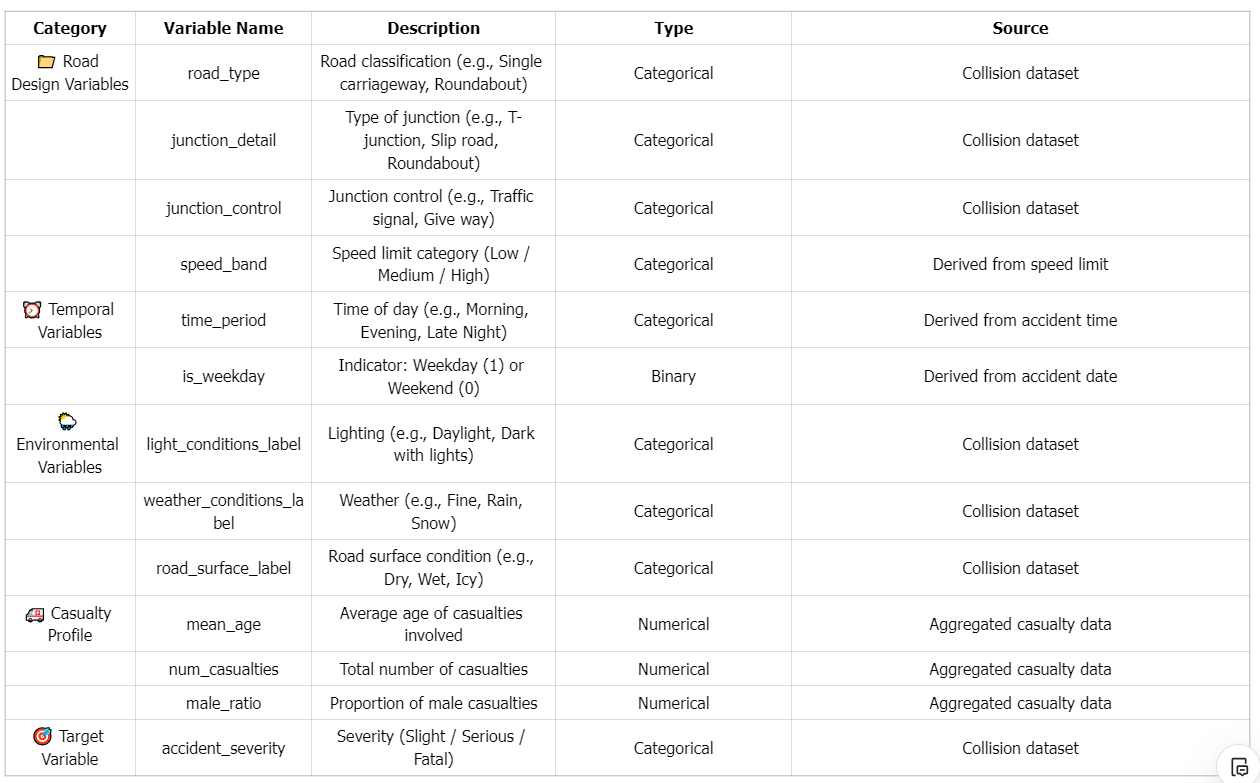

In [13]:
from IPython.display import Image
Image("variables_table.png")


In [14]:
# ✅ Import Libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import MultiPolygon
import folium
from folium.plugins import HeatMap
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from scipy.stats import chi2_contingency, f_oneway
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import scipy.spatial
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import shap
from shapely.geometry import Point
import shapely  # 添加这一行


# ✅ Data URL
collision_url = "https://raw.githubusercontent.com/shanchengnb/datascinece/refs/heads/main/transport/roadcollision.csv"
casualties_url = "https://raw.githubusercontent.com/shanchengnb/datascinece/refs/heads/main/transport/roadcasualties1.csv"
geo_data_url = "https://raw.githubusercontent.com/shanchengnb/datascinece/refs/heads/main/london_merged.geojson"
# ✅ Read Data
collision_df = pd.read_csv(collision_url)
casualties_df = pd.read_csv(casualties_url)
london_geo = gpd.read_file(geo_data_url)

In [15]:
#Data filtering
#Streamlining collision_df (accident data)
collision_selected_cols = [
    'accident_index', 'accident_year', 'date', 'day_of_week', 'time',
    'longitude', 'latitude', 'lsoa_of_accident_location', 'accident_severity',
    'road_type', 'speed_limit', 'junction_detail', 'junction_control',
    'light_conditions', 'weather_conditions', 'road_surface_conditions',
    'urban_or_rural_area', 'trunk_road_flag' 
]

collision_df_reduced = collision_df[collision_selected_cols].copy()

# Streamlining casualties_df (victim data)
casualties_selected_cols = [
    'accident_index', 'accident_year', 'casualty_severity', 'casualty_type',
    'casualty_class', 'sex_of_casualty', 'age_of_casualty', 
    'casualty_imd_decile'  
]
casualties_df_reduced = casualties_df[casualties_selected_cols].copy()


# Streamlined london_geo (geography + statistical area data)
geo_selected_cols = ['neighbourhood', 'Borough', 'geometry']
london_geo_reduced = london_geo[geo_selected_cols].copy()

# Output each simplified dataset structure confirmation
print("✅ collision_df_reduced List：", collision_df_reduced.columns.tolist())
print("✅ casualties_df_reduced List：", casualties_df_reduced.columns.tolist())
print("✅ london_geo_reduced List：", london_geo_reduced.columns.tolist())

# Aggregate victim information by accident_index (number of people per accident, mean age, gender ratio, etc.)
casualties_agg = casualties_df_reduced.groupby('accident_index').agg({
    'casualty_severity': 'count',  # Number of victims per accident
    'age_of_casualty': 'mean',     # average age
    'sex_of_casualty': lambda x: (x == 1).sum() / len(x)  #Male proportion (1=male)
}).reset_index()

# Rename column names to be clearer
casualties_agg.rename(columns={
    'casualty_severity': 'num_casualties',
    'age_of_casualty': 'mean_age',
    'sex_of_casualty': 'male_ratio'
}, inplace=True)

# Check the number of rows processed
print("Victim statistics after processing：", casualties_agg.shape)
print(casualties_agg.head())

# Use streamlined aggregated victim data to merge
merged_df = pd.merge(
    collision_df_reduced,
    casualties_agg,
    on='accident_index',
    how='left'
)

print("The size of the data after the merge is completed：", merged_df.shape)
print(merged_df.head())


✅ collision_df_reduced List： ['accident_index', 'accident_year', 'date', 'day_of_week', 'time', 'longitude', 'latitude', 'lsoa_of_accident_location', 'accident_severity', 'road_type', 'speed_limit', 'junction_detail', 'junction_control', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'urban_or_rural_area', 'trunk_road_flag']
✅ casualties_df_reduced List： ['accident_index', 'accident_year', 'casualty_severity', 'casualty_type', 'casualty_class', 'sex_of_casualty', 'age_of_casualty', 'casualty_imd_decile']
✅ london_geo_reduced List： ['neighbourhood', 'Borough', 'geometry']
Victim statistics after processing： (28937, 4)
  accident_index  num_casualties   mean_age  male_ratio
0    2.01904E+12            2224  38.295863    0.582284
1    2.01905E+12            2673  38.355406    0.588477
2    2.01906E+12               4  32.750000    0.500000
3    2.01907E+12            2039  39.220696    0.594899
4    2.01911E+12            1052  38.652091    0.565589
The size of the d

In [16]:
#Spatial join
import geopandas as gpd
from shapely.geometry import Point

# 1️⃣ Ensure london_geo uses the WGS84 coordinate system (latitude/longitude)
london_geo = london_geo.to_crs(epsg=4326)

# 2️⃣ Convert merged_df to a GeoDataFrame (create geometry points from longitude and latitude)
merged_gdf = gpd.GeoDataFrame(
    merged_df,
    geometry=gpd.points_from_xy(merged_df['longitude'], merged_df['latitude']),
    crs="EPSG:4326"
)

# 3️⃣ Perform spatial join: match each accident to the corresponding London borough
merged_with_borough = gpd.sjoin(
    merged_gdf,
    london_geo[['geometry', 'Borough']],
    how='left',
    predicate='within'  # Checks which borough polygon each accident point falls within
)

# 4️⃣ Check the results
print("✅ Spatial join successful! Number of records matched to a Borough:", merged_with_borough['Borough'].notna().sum())
print(merged_with_borough[['accident_index', 'Borough']].head())

# Define the list of Inner London boroughs (based on official ONS definition)
inner_london_boroughs = [
    'Camden', 'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Islington',
    'Kensington and Chelsea', 'Lambeth', 'Lewisham', 'Southwark',
    'Tower Hamlets', 'Wandsworth', 'Westminster', 'City of London'
]

# Filter the dataset to include only records within Inner London
inner_london_df = merged_with_borough[merged_with_borough['Borough'].isin(inner_london_boroughs)].copy()

# Output the result
print(f"✅ Number of records in Inner London: {inner_london_df.shape[0]}")
print(inner_london_df[['accident_index', 'Borough']].drop_duplicates().head())


✅ Spatial join successful! Number of records matched to a Borough: 90342
    accident_index      Borough
0  2019010000000.0  Westminster
1  2019010000000.0       Camden
2  2019010000000.0       Camden
3  2019010000000.0        Brent
4  2019010000000.0      Croydon
✅ Number of records in Inner London: 41744
     accident_index        Borough
0   2019010000000.0    Westminster
1   2019010000000.0         Camden
5   2019010000000.0      Southwark
9   2019010000000.0      Islington
10  2019010000000.0  Tower Hamlets


In [17]:
# Time processing

# Ensure the 'date' column is in datetime format
inner_london_df['date'] = pd.to_datetime(inner_london_df['date'], errors='coerce')

# Extract year, month, and day from the date
inner_london_df['year'] = inner_london_df['date'].dt.year
inner_london_df['month'] = inner_london_df['date'].dt.month
inner_london_df['day'] = inner_london_df['date'].dt.day

# Extract hour from the 'time' column (e.g., '14:20' -> 14)
inner_london_df['time'] = inner_london_df['time'].astype(str)
inner_london_df['hour'] = pd.to_numeric(inner_london_df['time'].str[:2], errors='coerce')

# Derive a time period category based on the hour
def map_hour_to_period(hour):
    if pd.isna(hour):
        return 'Unknown'
    elif 5 <= hour < 10:
        return 'Early Morning'
    elif 10 <= hour < 15:
        return 'Midday'
    elif 15 <= hour < 19:
        return 'Evening'
    elif 19 <= hour < 24:
        return 'Night'
    else:
        return 'Late Night'

inner_london_df['time_period'] = inner_london_df['hour'].apply(map_hour_to_period)

# Derive a binary variable for whether the day is a weekday (1) or weekend (0)
# Assuming 'day_of_week': 1 = Sunday, 7 = Saturday (as in UK STATS19)
inner_london_df['is_weekday'] = inner_london_df['day_of_week'].apply(lambda x: 0 if x in [1, 7] else 1)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9164\1160410945.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  inner_london_df['date'] = pd.to_datetime(inner_london_df['date'], errors='coerce')


In [18]:
# 1️⃣ Map 'road_type' codes to descriptive labels (based on DfT definitions)
road_type_map = {
    1: 'Roundabout',
    2: 'One_way_street',
    3: 'Dual_carriageway',
    6: 'Single_carriageway',
    7: 'Slip_road',
    9: 'Unknown'
}
inner_london_df['road_type'] = inner_london_df['road_type'].map(road_type_map)

# 2️⃣ Map 'junction_detail' codes to descriptive labels
junction_detail_map = {
    1: 'Not_at_junction',
    2: 'T_or_staggered_junction',
    3: 'Crossroads',
    5: 'Slip_road',
    6: 'Roundabout',
    7: 'Mini_roundabout',
    8: 'Private_drive',
    9: 'Other_junction',
    99: 'Unknown'
}
inner_london_df['junction_detail'] = inner_london_df['junction_detail'].map(junction_detail_map)

# 3️⃣ Map 'junction_control' codes to descriptive labels
junction_control_map = {
    1: 'Authorised_person',
    2: 'Traffic_signal',
    3: 'Stop_sign',
    4: 'Give_way_or_unmarked',
    9: 'Unknown'
}
inner_london_df['junction_control'] = inner_london_df['junction_control'].map(junction_control_map)

# 4️⃣ Categorize 'speed_limit' into bands
def map_speed_band(speed):
    if speed <= 20:
        return 'Low'
    elif speed <= 30:
        return 'Medium'
    else:
        return 'High'

inner_london_df['speed_band'] = inner_london_df['speed_limit'].apply(map_speed_band)


In [19]:
# 1️⃣ Light conditions (add new column: light_conditions_label)
light_conditions_map = {
    1: 'Daylight',
    4: 'Dark_lights_lit',
    5: 'Dark_lights_unlit',
    6: 'Dark_no_lights',
    7: 'Dark_lights_unknown',
    9: 'Unknown'
}
inner_london_df['light_conditions_label'] = inner_london_df['light_conditions'].map(light_conditions_map)

# 2️⃣ Weather conditions (add new column: weather_conditions_label)
weather_conditions_map = {
    1: 'Fine_no_wind',
    2: 'Raining_no_wind',
    3: 'Snowing_no_wind',
    4: 'Fine_with_wind',
    5: 'Raining_with_wind',
    6: 'Snowing_with_wind',
    7: 'Fog_or_mist',
    8: 'Other',
    9: 'Unknown'
}
inner_london_df['weather_conditions_label'] = inner_london_df['weather_conditions'].map(weather_conditions_map)

# 3️⃣ Road surface conditions (add new column: road_surface_label)
road_surface_map = {
    1: 'Dry',
    2: 'Wet_damp',
    3: 'Snow',
    4: 'Frost_ice',
    5: 'Flood_over_3cm',
    6: 'Oil_or_diesel',
    7: 'Mud',
    9: 'Unknown'
}
inner_london_df['road_surface_label'] = inner_london_df['road_surface_conditions'].map(road_surface_map)

# 4️⃣ Urban/Rural classification (add new column: urban_rural_label)
urban_rural_map = {
    1: 'Urban',
    2: 'Rural',
    3: 'Unallocated'
}
inner_london_df['urban_rural_label'] = inner_london_df['urban_or_rural_area'].map(urban_rural_map)


In [20]:
#Final Datasets
inner_london_df

,accident_index,accident_year,date,day_of_week,time,longitude,latitude,lsoa_of_accident_location,accident_severity,road_type,...,month,day,hour,time_period,is_weekday,speed_band,light_conditions_label,weather_conditions_label,road_surface_label,urban_rural_label
0,2019010000000.0,2019,2019-02-18,2,17,-0.153842,51.508057,E01004762,Slight,Roundabout,...,2,18,17,Evening,1,Medium,Daylight,Fine_no_wind,Dry,Urban
1,2019010000000.0,2019,2019-01-01,3,1,-0.124193,51.526795,E01000943,Slight,Single_carriageway,...,1,1,1,Late Night,1,Medium,Dark_lights_lit,Fine_no_wind,Dry,Urban
2,2019010000000.0,2019,2019-01-01,3,1,-0.191044,51.546387,E01000973,Serious,Single_carriageway,...,1,1,1,Late Night,1,Low,Dark_lights_lit,Fine_no_wind,Dry,Urban
5,2019010000000.0,2019,2019-01-01,3,2,-0.088978,51.489509,E01003972,Slight,Single_carriageway,...,1,1,2,Late Night,1,Low,Dark_lights_lit,Fine_no_wind,Dry,Urban
9,2019010000000.0,2019,2019-01-01,3,2,-0.087182,51.549218,E01002776,Slight,Dual_carriageway,...,1,1,2,Late Night,1,Low,Dark_lights_lit,Fine_no_wind,Dry,Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277143,2023480000000.0,2023,2023-12-15,6,19,-0.080137,51.517790,E01032739,Serious,Single_carriageway,...,12,15,19,Night,1,Low,Dark_lights_lit,Fine_no_wind,Dry,Urban
277144,2023480000000.0,2023,2023-12-14,5,20,-0.097510,51.517678,E01000001,Slight,Single_carriageway,...,12,14,20,Night,1,Low,Dark_lights_lit,Fine_no_wind,Wet_damp,Urban
277145,2023480000000.0,2023,2023-12-20,4,18,-0.105334,51.518434,E01032740,Serious,Single_carriageway,...,12,20,18,Evening,1,Low,Dark_lights_lit,Fine_no_wind,Dry,Urban
277146,2023480000000.0,2023,2023-12-23,7,23,-0.078970,51.518122,E01032739,Slight,Single_carriageway,...,12,23,23,Night,0,Low,Dark_lights_lit,Raining_no_wind,Wet_damp,Urban


## Methodology

[[ go back to the top ]](#Table-of-contents)

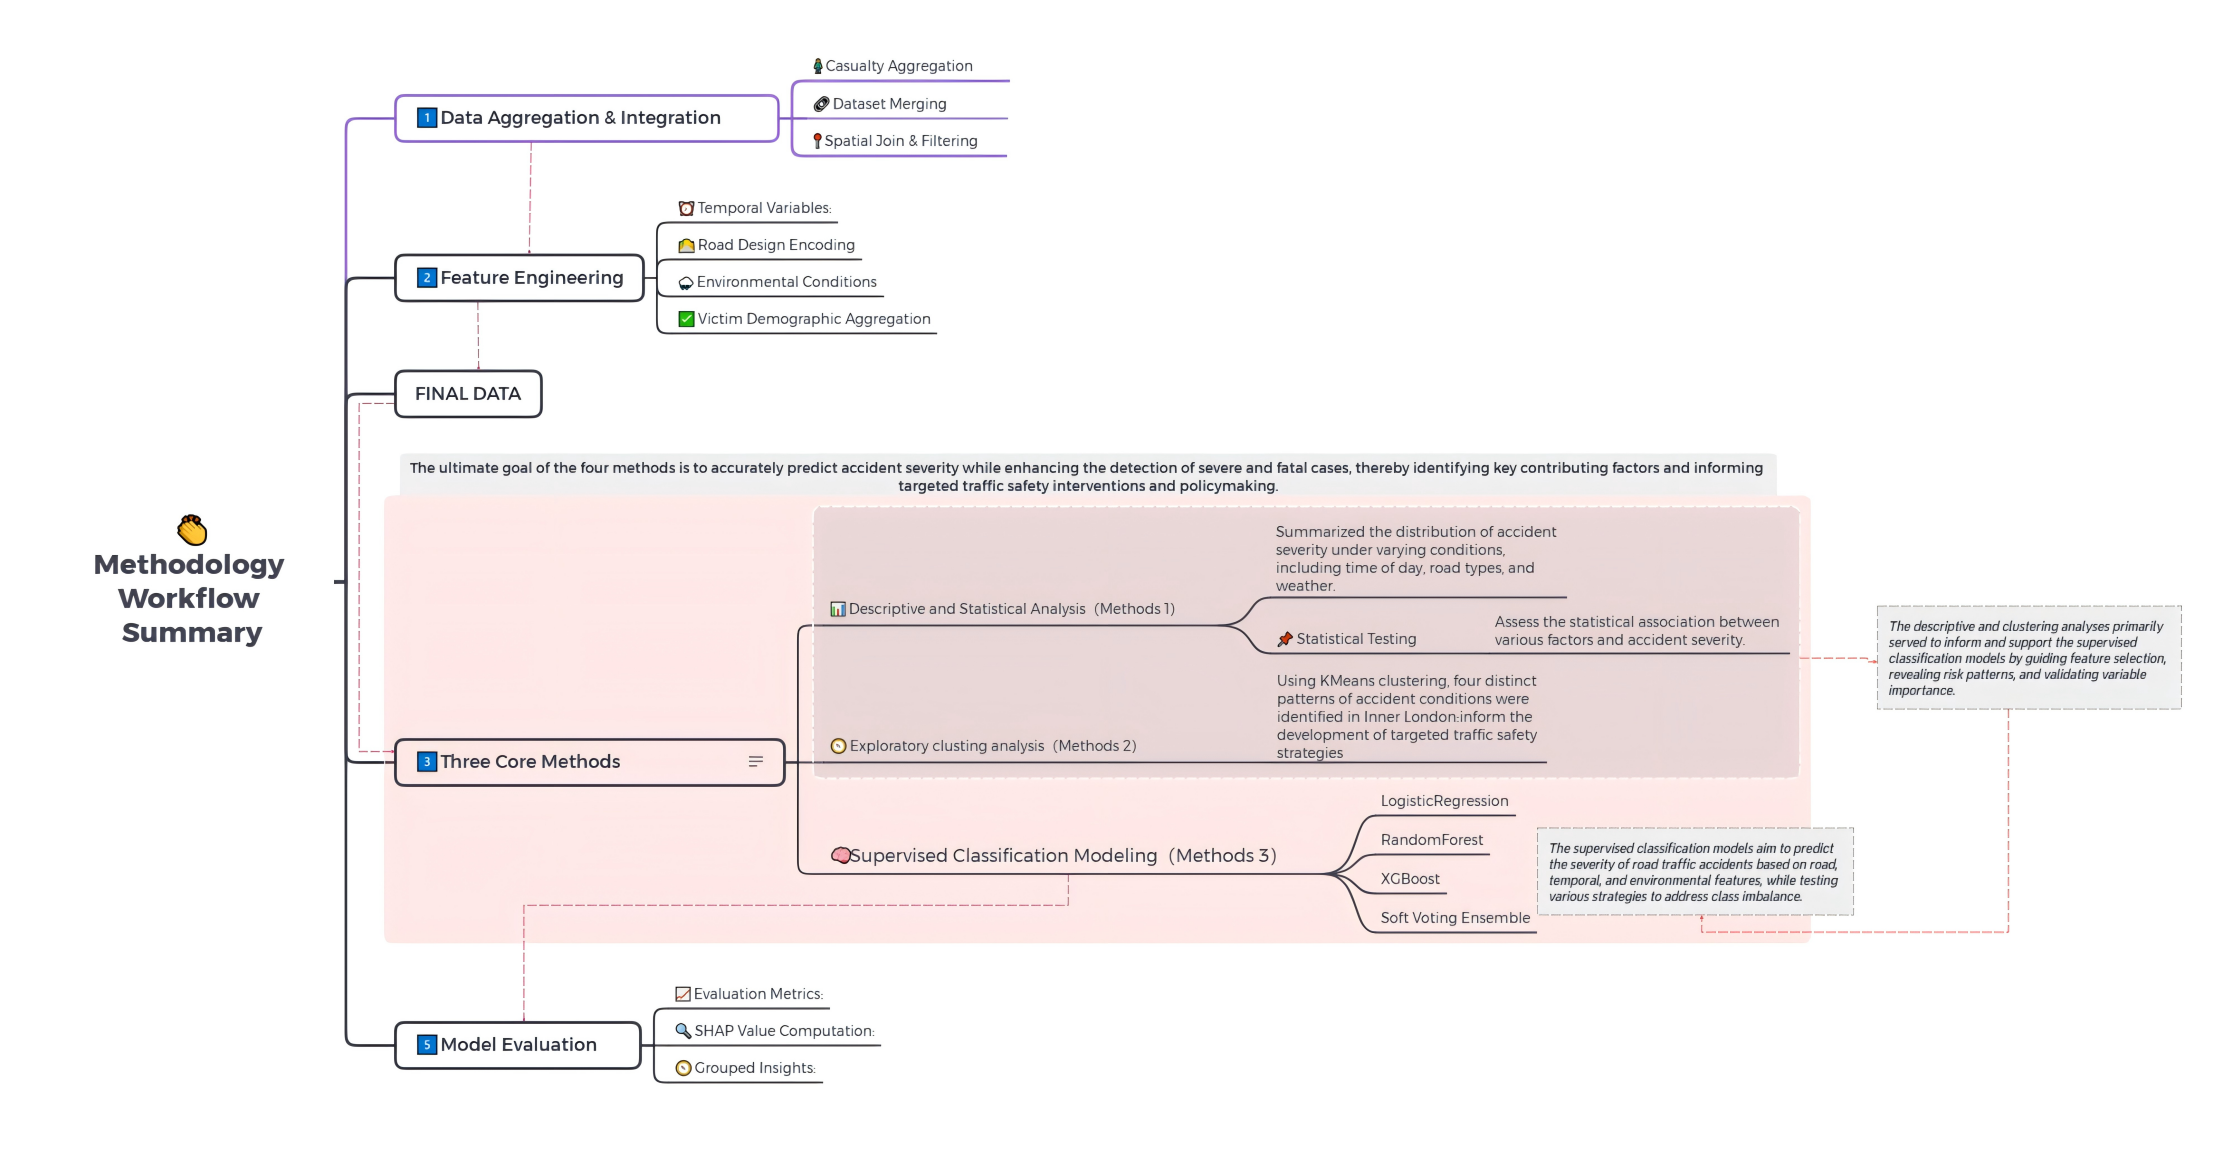

In [22]:
from IPython.display import Image, display

# Display a local image (make sure 'flowchart.png' is in the current working directory)
display(Image(filename='Welcome to Xmind AI (5)(1).png'))

We used three main methods: Supervised classified models (logistic regression, random forest, XGBoost)for accident severity prediction, supplemented by Descriptive and Statistical Analysis and KMeans clustering for statistical association and exploratory pattern analysis.

### Descriptive and Statistical Analysis（Methods 1）


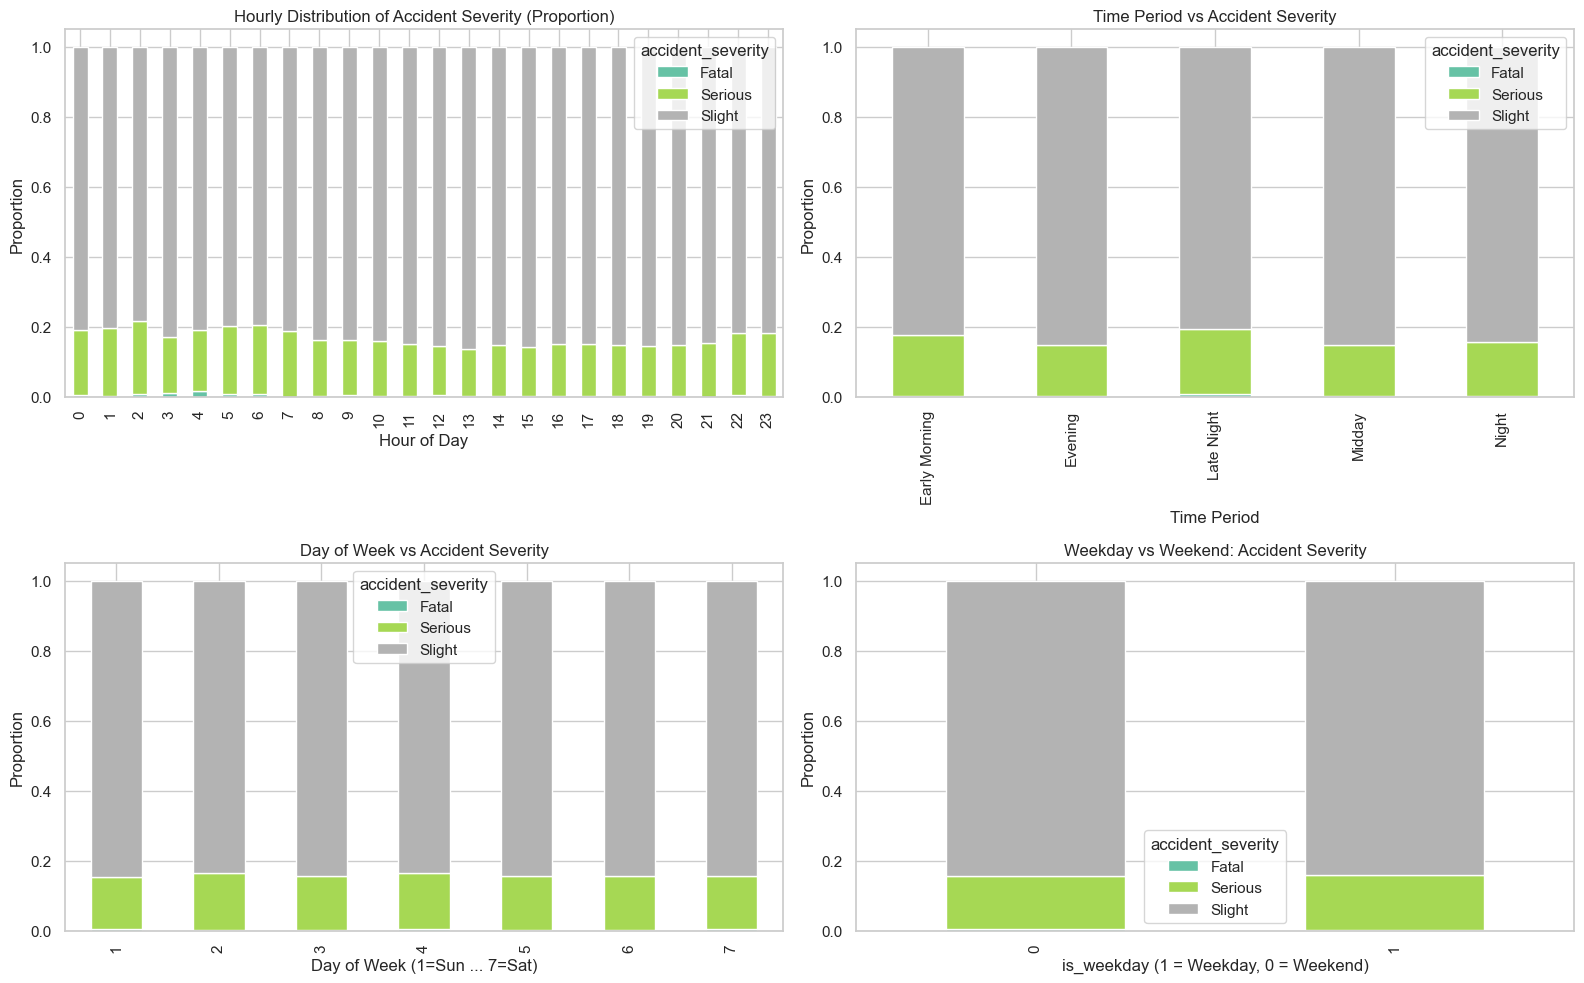

In [25]:

hour_severity = inner_london_df.groupby(['hour', 'accident_severity']).size().unstack(fill_value=0)
hour_severity_ratio = hour_severity.div(hour_severity.sum(axis=1), axis=0).round(3)
hour_analysis = hour_severity.copy()
hour_analysis['Total'] = hour_severity.sum(axis=1)
hour_analysis = hour_analysis.merge(hour_severity_ratio, left_index=True, right_index=True, suffixes=('_count', '_ratio'))

time_severity = inner_london_df.groupby(['time_period', 'accident_severity']).size().unstack(fill_value=0)
time_severity_ratio = time_severity.div(time_severity.sum(axis=1), axis=0).round(3)
time_analysis = time_severity.copy()
time_analysis['Total'] = time_severity.sum(axis=1)
time_analysis = time_analysis.merge(time_severity_ratio, left_index=True, right_index=True, suffixes=('_count', '_ratio'))

weekday_severity = inner_london_df.groupby(['is_weekday', 'accident_severity']).size().unstack(fill_value=0)
weekday_severity_ratio = weekday_severity.div(weekday_severity.sum(axis=1), axis=0).round(3)
weekday_analysis = weekday_severity.copy()
weekday_analysis['Total'] = weekday_severity.sum(axis=1)
weekday_analysis = weekday_analysis.merge(weekday_severity_ratio, left_index=True, right_index=True, suffixes=('_count', '_ratio'))

day_severity = inner_london_df.groupby(['day_of_week', 'accident_severity']).size().unstack(fill_value=0)
day_severity_ratio = day_severity.div(day_severity.sum(axis=1), axis=0).round(3)
day_analysis = day_severity.copy()
day_analysis['Total'] = day_severity.sum(axis=1)
day_analysis = day_analysis.merge(day_severity_ratio, left_index=True, right_index=True, suffixes=('_count', '_ratio'))


# Set style and overall figure size
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # 2 rows × 2 columns

# 1️⃣ Hourly accident severity
hour_plot = hour_severity.div(hour_severity.sum(axis=1), axis=0)
hour_plot.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[0, 0])
axes[0, 0].set_title("Hourly Distribution of Accident Severity (Proportion)")
axes[0, 0].set_xlabel("Hour of Day")
axes[0, 0].set_ylabel("Proportion")

# 2️⃣ Time period vs severity
time_plot = time_severity.div(time_severity.sum(axis=1), axis=0)
time_plot.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[0, 1])
axes[0, 1].set_title("Time Period vs Accident Severity")
axes[0, 1].set_xlabel("Time Period")
axes[0, 1].set_ylabel("Proportion")

# 3️⃣ Day of week vs severity
day_plot = day_severity.div(day_severity.sum(axis=1), axis=0)
day_plot.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[1, 0])
axes[1, 0].set_title("Day of Week vs Accident Severity")
axes[1, 0].set_xlabel("Day of Week (1=Sun ... 7=Sat)")
axes[1, 0].set_ylabel("Proportion")

# 4️⃣ Weekday vs weekend severity
weekday_plot = weekday_severity.div(weekday_severity.sum(axis=1), axis=0)
weekday_plot.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[1, 1])
axes[1, 1].set_title("Weekday vs Weekend: Accident Severity")
axes[1, 1].set_xlabel("is_weekday (1 = Weekday, 0 = Weekend)")
axes[1, 1].set_ylabel("Proportion")

# Adjust layout
plt.tight_layout()
plt.show()

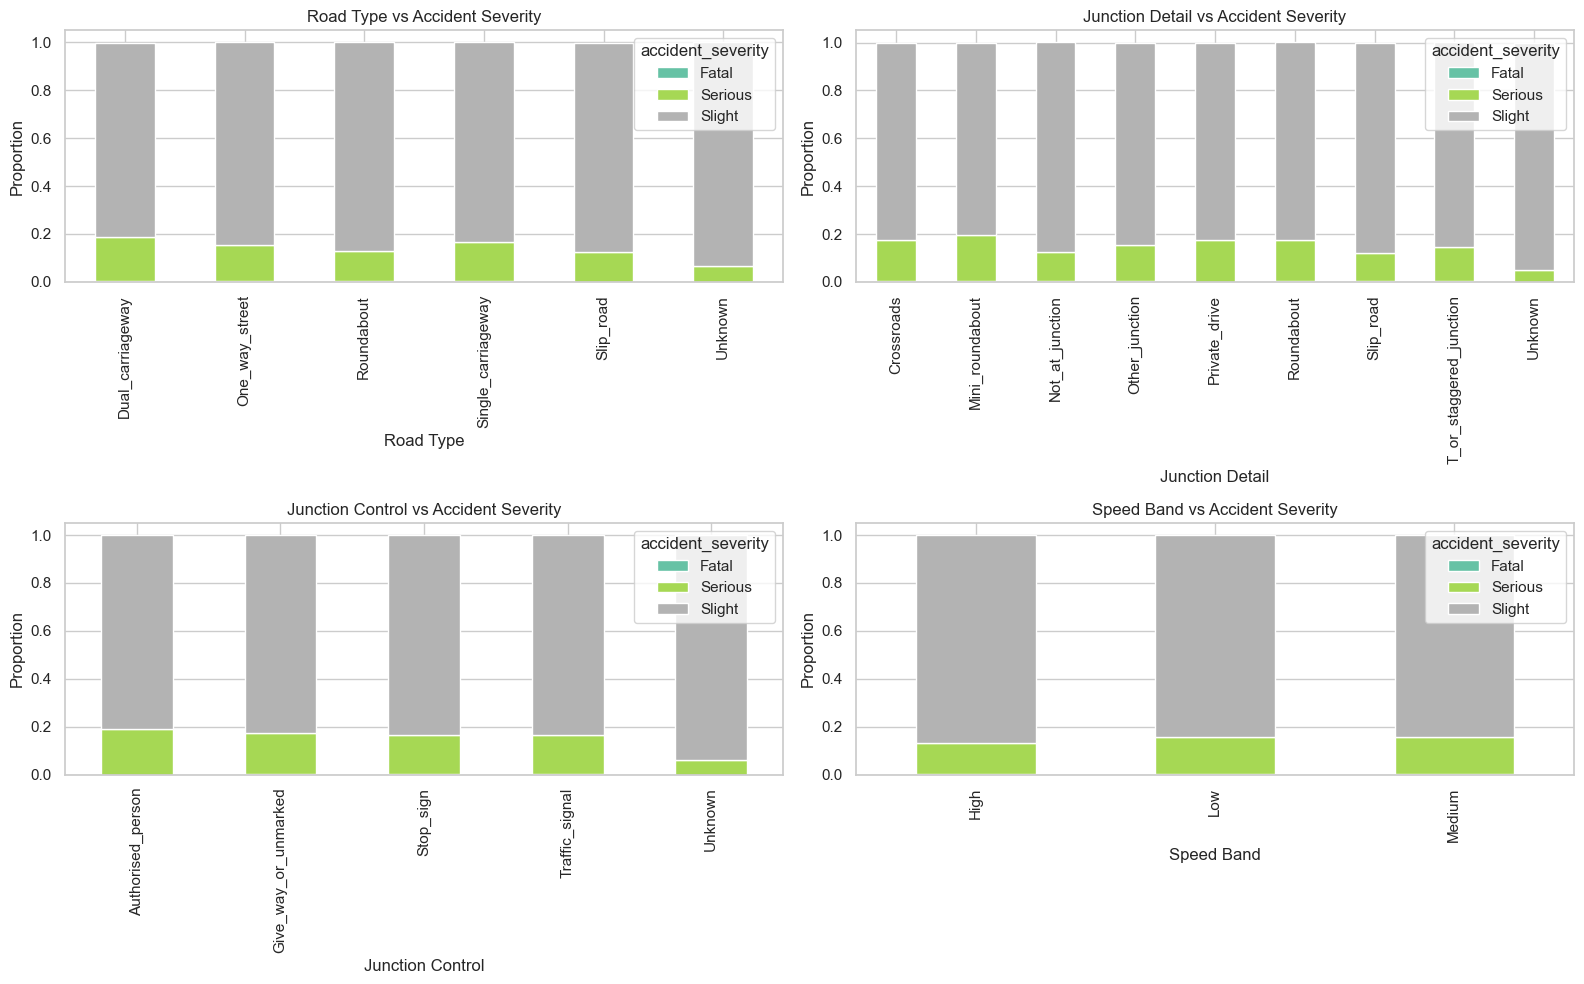

In [26]:
# 1️⃣ road_type vs accident severity
# Group by road type and accident severity, then calculate proportion
road_severity = inner_london_df.groupby(['road_type', 'accident_severity']).size().unstack(fill_value=0)
road_ratio = road_severity.div(road_severity.sum(axis=1), axis=0).round(3)

# 2️⃣ junction_detail vs accident severity
# Analyze severity distribution based on the type of junction
junction_detail_severity = inner_london_df.groupby(['junction_detail', 'accident_severity']).size().unstack(fill_value=0)
junction_detail_ratio = junction_detail_severity.div(junction_detail_severity.sum(axis=1), axis=0).round(3)

# 3️⃣ junction_control vs accident severity
# Analyze how different types of junction control relate to accident severity
junction_ctrl_severity = inner_london_df.groupby(['junction_control', 'accident_severity']).size().unstack(fill_value=0)
junction_ctrl_ratio = junction_ctrl_severity.div(junction_ctrl_severity.sum(axis=1), axis=0).round(3)

# 4️⃣ speed_band vs accident severity
# Compare severity levels across different speed categories
speed_severity = inner_london_df.groupby(['speed_band', 'accident_severity']).size().unstack(fill_value=0)
speed_ratio = speed_severity.div(speed_severity.sum(axis=1), axis=0).round(3)

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))  # You can adjust figsize if needed

# 1️⃣ Road Type
road_ratio.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[0, 0])
axes[0, 0].set_title("Road Type vs Accident Severity")
axes[0, 0].set_xlabel("Road Type")
axes[0, 0].set_ylabel("Proportion")

# 2️⃣ Junction Detail
junction_detail_ratio.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[0, 1])
axes[0, 1].set_title("Junction Detail vs Accident Severity")
axes[0, 1].set_xlabel("Junction Detail")
axes[0, 1].set_ylabel("Proportion")

# 3️⃣ Junction Control
junction_ctrl_ratio.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[1, 0])
axes[1, 0].set_title("Junction Control vs Accident Severity")
axes[1, 0].set_xlabel("Junction Control")
axes[1, 0].set_ylabel("Proportion")

# 4️⃣ Speed Band
speed_ratio.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[1, 1])
axes[1, 1].set_title("Speed Band vs Accident Severity")
axes[1, 1].set_xlabel("Speed Band")
axes[1, 1].set_ylabel("Proportion")

# Improve layout
plt.tight_layout()
plt.show()



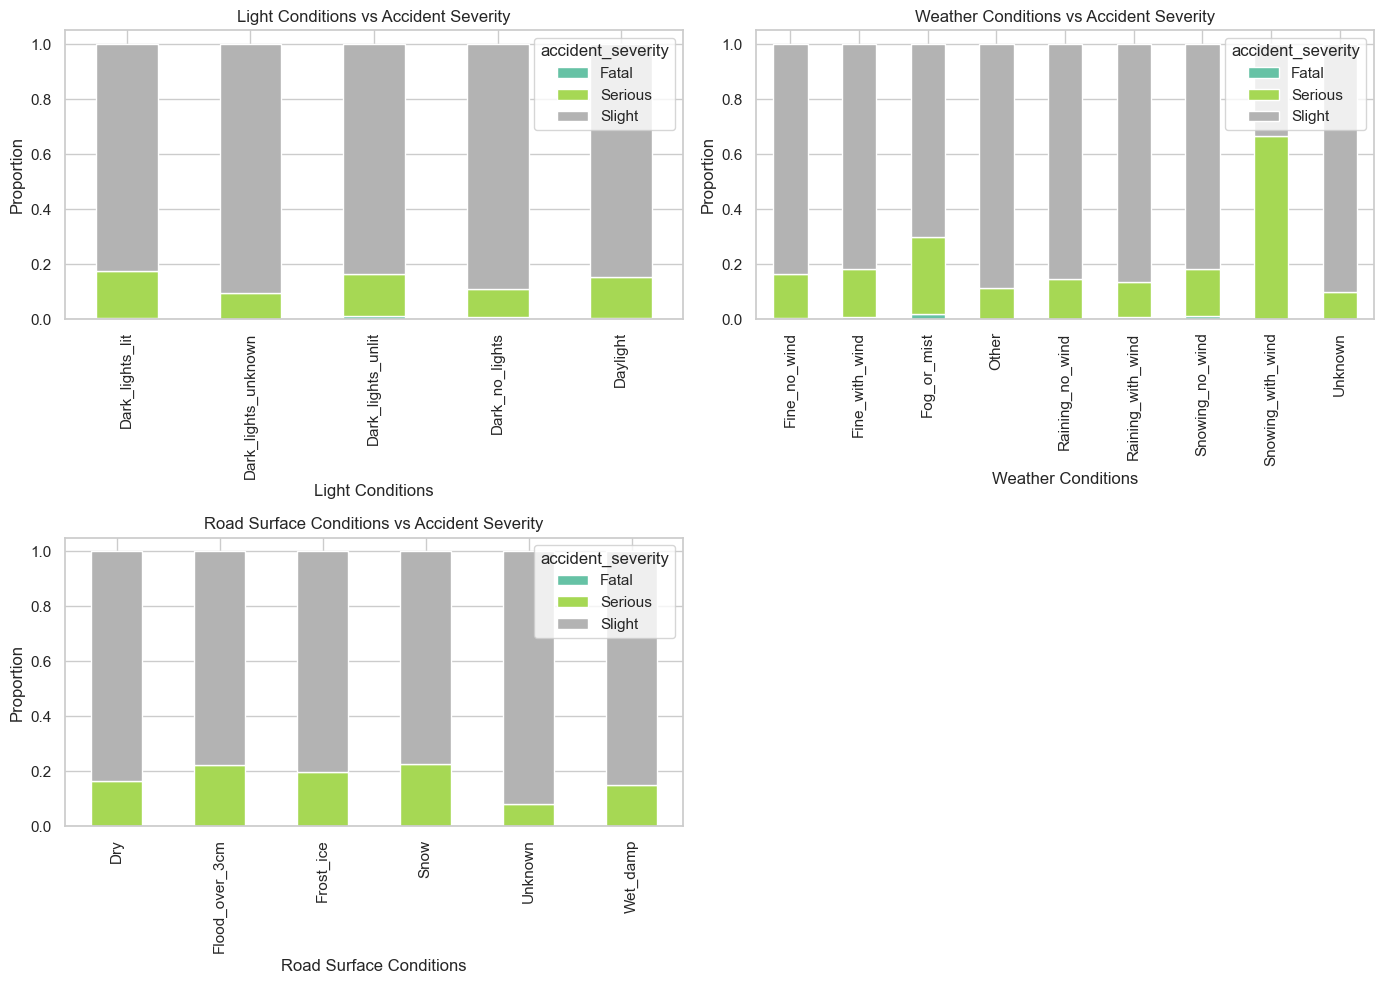

In [27]:
import matplotlib.pyplot as plt
# 计算每种 light_conditions_label 下的事故严重程度数量
light_severity = inner_london_df.groupby(['light_conditions_label', 'accident_severity']).size().unstack(fill_value=0)
light_ratio = light_severity.div(light_severity.sum(axis=1), axis=0)

weather_severity = inner_london_df.groupby(['weather_conditions_label', 'accident_severity']).size().unstack(fill_value=0)
weather_ratio = weather_severity.div(weather_severity.sum(axis=1), axis=0)

surface_severity = inner_london_df.groupby(['road_surface_label', 'accident_severity']).size().unstack(fill_value=0)
surface_ratio = surface_severity.div(surface_severity.sum(axis=1), axis=0)

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Light Conditions vs Accident Severity
light_ratio.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[0, 0])
axes[0, 0].set_title("Light Conditions vs Accident Severity")
axes[0, 0].set_xlabel("Light Conditions")
axes[0, 0].set_ylabel("Proportion")

# Plot Weather Conditions vs Accident Severity
weather_ratio.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[0, 1])
axes[0, 1].set_title("Weather Conditions vs Accident Severity")
axes[0, 1].set_xlabel("Weather Conditions")
axes[0, 1].set_ylabel("Proportion")

# Plot Road Surface Conditions vs Accident Severity
surface_ratio.plot(kind='bar', stacked=True, colormap='Set2', ax=axes[1, 0])
axes[1, 0].set_title("Road Surface Conditions vs Accident Severity")
axes[1, 0].set_xlabel("Road Surface Conditions")
axes[1, 0].set_ylabel("Proportion")

# Hide the empty subplot (bottom right)
fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()


####  Significance detection

In [29]:

# 1️⃣ Contingency table: Time Period vs Accident Severity
time_ct = pd.crosstab(inner_london_df['time_period'], inner_london_df['accident_severity'])

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(time_ct)

# Output results
print("▶️ Chi-squared Statistic:", round(chi2, 2))
print("▶️ Degrees of Freedom:", dof)
print("▶️ P-value:", round(p, 5))
print("▶️ Statistically Significant:", "✅ Yes" if p < 0.05 else "❌ No")
# Interpretation: Accident severity varies significantly across different time periods.

# 2️⃣ Contingency table: Weekday vs Accident Severity
weekday_ct = pd.crosstab(inner_london_df['is_weekday'], inner_london_df['accident_severity'])

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(weekday_ct)

# Output results
print("▶️ Chi-squared Statistic:", round(chi2, 2))
print("▶️ Degrees of Freedom:", dof)
print("▶️ P-value:", round(p, 5))
print("▶️ Statistically Significant:", "✅ Yes" if p < 0.05 else "❌ No")

# 3️⃣ Contingency table: Hour of Day vs Accident Severity
hour_ct = pd.crosstab(inner_london_df['hour'], inner_london_df['accident_severity'])

# Perform Chi-squared test
chi2, p, dof, expected = chi2_contingency(hour_ct)

# Output results
print("▶️ Chi-squared Statistic:", round(chi2, 2))
print("▶️ Degrees of Freedom:", dof)
print("▶️ P-value:", round(p, 5))
print("▶️ Statistically Significant:", "✅ Yes" if p < 0.05 else "❌ No")

# Contingency table: road_type vs accident_severity
road_ct = pd.crosstab(inner_london_df['road_type'], inner_london_df['accident_severity'])
chi2, p, dof, expected = chi2_contingency(road_ct)

print("🚧 [road_type] vs [accident_severity]")
print("▶️ Chi²:", round(chi2, 2))
print("▶️ df:", dof)
print("▶️ P-value:", round(p, 5))
print("▶️ Significant:", "✅ Yes" if p < 0.05 else "❌ No")

# Contingency table: junction_detail vs accident_severity
junction_detail_ct = pd.crosstab(inner_london_df['junction_detail'], inner_london_df['accident_severity'])
chi2, p, dof, expected = chi2_contingency(junction_detail_ct)

print("🧩 [junction_detail] vs [accident_severity]")
print("▶️ Chi²:", round(chi2, 2))
print("▶️ df:", dof)
print("▶️ P-value:", round(p, 5))
print("▶️ Significant:", "✅ Yes" if p < 0.05 else "❌ No")

# Contingency table: junction_control vs accident_severity
junction_control_ct = pd.crosstab(inner_london_df['junction_control'], inner_london_df['accident_severity'])
chi2, p, dof, expected = chi2_contingency(junction_control_ct)

print("🚦 [junction_control] vs [accident_severity]")
print("▶️ Chi²:", round(chi2, 2))
print("▶️ df:", dof)
print("▶️ P-value:", round(p, 5))
print("▶️ Significant:", "✅ Yes" if p < 0.05 else "❌ No")

# Contingency table: speed_band vs accident_severity
speed_band_ct = pd.crosstab(inner_london_df['speed_band'], inner_london_df['accident_severity'])
chi2, p, dof, expected = chi2_contingency(speed_band_ct)

print("⏱️ [speed_band] vs [accident_severity]")
print("▶️ Chi²:", round(chi2, 2))
print("▶️ df:", dof)
print("▶️ P-value:", round(p, 5))
print("▶️ Significant:", "✅ Yes" if p < 0.05 else "❌ No")

# 1️⃣ Light Conditions
light_ct = pd.crosstab(inner_london_df['light_conditions_label'], inner_london_df['accident_severity'])
chi2_1, p_1, dof_1, _ = chi2_contingency(light_ct)
print("💡 [light_conditions_label] vs [accident_severity]")
print(f"▶️ Chi²: {round(chi2_1, 2)} | df: {dof_1} | p-value: {round(p_1, 5)} | Significant: {'✅ Yes' if p_1 < 0.05 else '❌ No'}\n")

# 2️⃣ Weather Conditions
weather_ct = pd.crosstab(inner_london_df['weather_conditions_label'], inner_london_df['accident_severity'])
chi2_2, p_2, dof_2, _ = chi2_contingency(weather_ct)
print("🌧️ [weather_conditions_label] vs [accident_severity]")
print(f"▶️ Chi²: {round(chi2_2, 2)} | df: {dof_2} | p-value: {round(p_2, 5)} | Significant: {'✅ Yes' if p_2 < 0.05 else '❌ No'}\n")

# 3️⃣ Road Surface Conditions
surface_ct = pd.crosstab(inner_london_df['road_surface_label'], inner_london_df['accident_severity'])
chi2_3, p_3, dof_3, _ = chi2_contingency(surface_ct)
print("🛣️ [road_surface_label] vs [accident_severity]")
print(f"▶️ Chi²: {round(chi2_3, 2)} | df: {dof_3} | p-value: {round(p_3, 5)} | Significant: {'✅ Yes' if p_3 < 0.05 else '❌ No'}\n")




▶️ Chi-squared Statistic: 76.25
▶️ Degrees of Freedom: 8
▶️ P-value: 0.0
▶️ Statistically Significant: ✅ Yes
▶️ Chi-squared Statistic: 1.96
▶️ Degrees of Freedom: 2
▶️ P-value: 0.37552
▶️ Statistically Significant: ❌ No
▶️ Chi-squared Statistic: 157.83
▶️ Degrees of Freedom: 46
▶️ P-value: 0.0
▶️ Statistically Significant: ✅ Yes
🚧 [road_type] vs [accident_severity]
▶️ Chi²: 315.47
▶️ df: 10
▶️ P-value: 0.0
▶️ Significant: ✅ Yes
🧩 [junction_detail] vs [accident_severity]
▶️ Chi²: 469.0
▶️ df: 16
▶️ P-value: 0.0
▶️ Significant: ✅ Yes
🚦 [junction_control] vs [accident_severity]
▶️ Chi²: 391.99
▶️ df: 8
▶️ P-value: 0.0
▶️ Significant: ✅ Yes
⏱️ [speed_band] vs [accident_severity]
▶️ Chi²: 6.67
▶️ df: 4
▶️ P-value: 0.15466
▶️ Significant: ❌ No
💡 [light_conditions_label] vs [accident_severity]
▶️ Chi²: 80.7 | df: 8 | p-value: 0.0 | Significant: ✅ Yes

🌧️ [weather_conditions_label] vs [accident_severity]
▶️ Chi²: 133.37 | df: 16 | p-value: 0.0 | Significant: ✅ Yes

🛣️ [road_surface_label] vs [

The analysis (Method 1) shows that accident severity in Inner London is strongly influenced by temporal, road design, and environmental factors. Serious and fatal crashes are more frequent between midnight and 4 a.m., especially on weekends, and often occur on single carriageways, high-speed roads, and uncontrolled or complex junctions like slip roads and roundabouts. Poor lighting, wet or icy surfaces, and severe weather further increase severity. Chi-squared tests confirm the significance of these variables (p < 0.001), while day type and speed limits show no strong association. KMeans clustering reveals four distinct accident patterns shaped by time, junction type, and traffic control, offering key insights for targeted safety interventions.


### Exploratory clusting analysis（Methods 2）

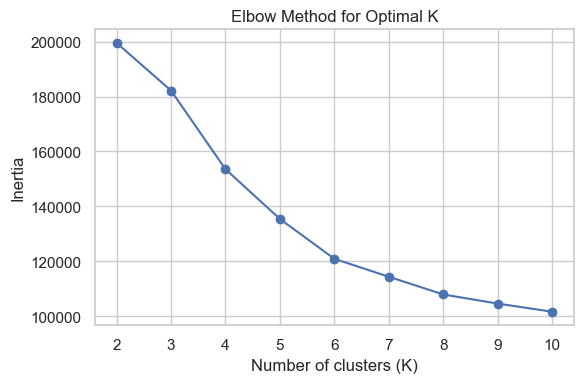

{'time_period': time_period  Early Morning  Evening  Late Night  Midday  Night
 cluster                                                       
 0                     0.01     0.41        0.00    0.30   0.28
 1                     0.52     0.00        0.18    0.29   0.00
 2                     0.00     0.50        0.00    0.15   0.35
 3                     0.26     0.20        0.12    0.19   0.23,
 'road_type': road_type  Dual_carriageway  One_way_street  Roundabout  Single_carriageway  \
 cluster                                                                       
 0                      0.15            0.08        0.04                0.62   
 1                      0.16            0.09        0.05                0.60   
 2                      0.15            0.09        0.04                0.60   
 3                      0.30            0.02        0.00                0.66   
 
 road_type  Slip_road  Unknown  
 cluster                        
 0               0.02     0.08  
 1    

In [32]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# 1️⃣ Feature selection
cluster_vars = [
    'hour', 'is_weekday', 'time_period',
    'road_type', 'junction_detail', 'junction_control', 'speed_band',
    'mean_age', 'num_casualties', 'male_ratio'
]

# 2️⃣ Remove rows with missing values
cluster_data = inner_london_df[cluster_vars + ['accident_severity']].dropna()

# 3️⃣ Standardize numerical variables
numeric_vars = ['hour', 'is_weekday', 'mean_age', 'num_casualties', 'male_ratio']
scaler = StandardScaler()
X_numeric = scaler.fit_transform(cluster_data[numeric_vars])

# 4️⃣ One-hot encode categorical variables (compatible with older versions of sklearn)
categorical_vars = ['time_period', 'road_type', 'junction_detail', 'junction_control', 'speed_band']
encoder = OneHotEncoder(handle_unknown='ignore')  # ✅ avoid errors on unseen categories
X_cat_sparse = encoder.fit_transform(cluster_data[categorical_vars])
X_cat = X_cat_sparse.toarray()  # ✅ convert to dense array for use with KMeans

# 5️⃣ Combine numeric and categorical features into one input matrix
X_cluster_full = np.hstack([X_numeric, X_cat])

inertia_list = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster_full)
    inertia_list.append(kmeans.inertia_)

# Visualizing the Elbow Plot
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia_list, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6️⃣ Perform clustering (K = 4)
kmeans_final = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans_final.fit_predict(X_cluster_full)

# 7️⃣ Add cluster labels to the original dataset
cluster_data['cluster'] = cluster_labels

# 8️⃣ View the distribution of accident severity by cluster
severity_distribution = pd.crosstab(
    cluster_data['cluster'], 
    cluster_data['accident_severity'], 
    normalize='index'
).round(2)

severity_distribution

# Analyze cluster-wise distribution across key categorical features (time + road environment)
categorical_vars = ['time_period', 'road_type', 'junction_detail', 'junction_control', 'speed_band']

# Add cluster labels back to the original inner_london_df (aligned with cluster_data index)
cluster_labels_full = pd.Series(cluster_data['cluster'].values, index=cluster_data.index, name='cluster')
inner_london_df_clustered = inner_london_df.loc[cluster_labels_full.index].copy()
inner_london_df_clustered['cluster'] = cluster_labels_full.values

# For each categorical variable, calculate its distribution (as proportions) across clusters
cluster_distributions = {}

for var in categorical_vars:
    dist = pd.crosstab(
        inner_london_df_clustered['cluster'],
        inner_london_df_clustered[var],
        normalize='index'
    ).round(2)
    cluster_distributions[var] = dist
cluster_distributions 



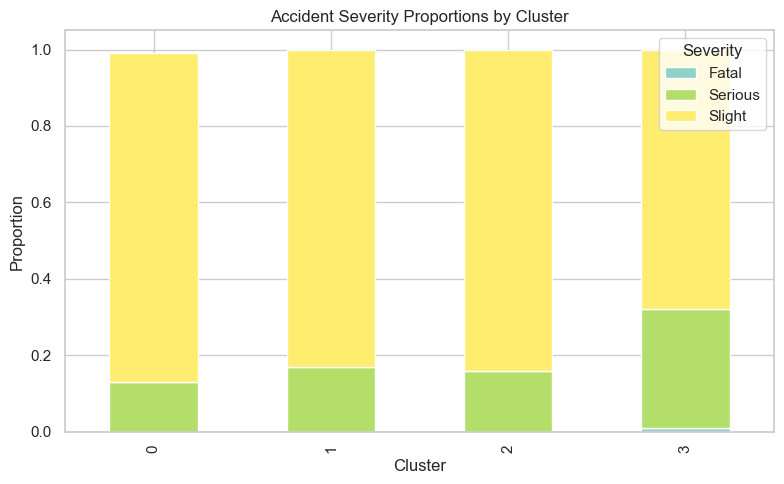

In [33]:
# Visualize the proportion of different accident severity levels
severity_distribution.plot(
    kind='bar', stacked=True, colormap='Set3',
    figsize=(8, 5)
)
plt.title("Accident Severity Proportions by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.legend(title="Severity")
plt.tight_layout()
plt.show()


<bound method Axes.set of <Axes: >>

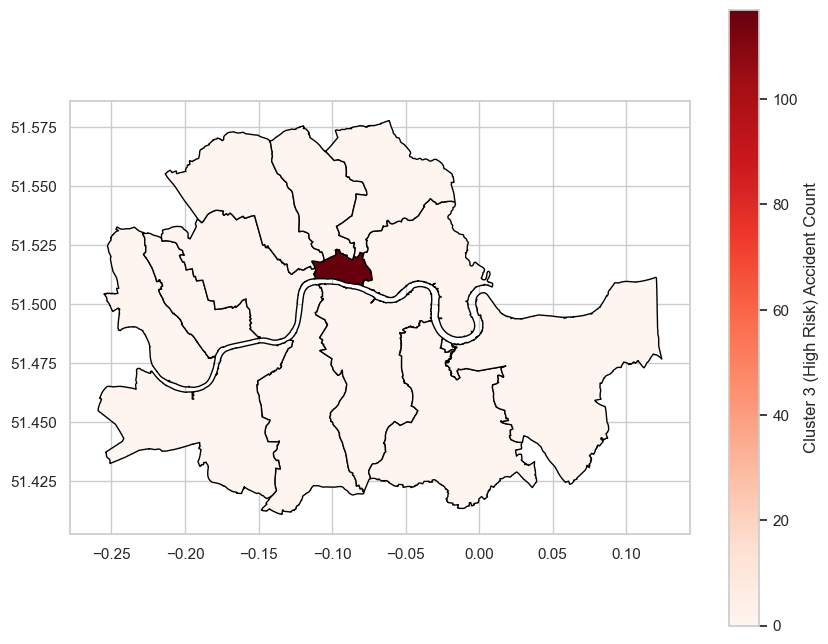

In [34]:
# Keep only necessary geometry columns
london_geo = london_geo[['Borough', 'geometry']]

# Add Borough information for merging
cluster_data_with_borough = cluster_data.copy()
cluster_data_with_borough['Borough'] = inner_london_df.loc[cluster_data_with_borough.index, 'Borough'].values

# Count number of accidents in each cluster per Borough
borough_cluster_dist = cluster_data_with_borough.groupby(['Borough', 'cluster']).size().unstack(fill_value=0)

# Merge with geographic boundaries
london_geo_cluster = london_geo.merge(borough_cluster_dist, on='Borough', how='left')

# Plot: Spatial distribution of Cluster 3 (assumed high-risk) across boroughs
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
london_geo_cluster.plot(
    column=3,  # Cluster 3
    cmap='Reds',
    legend=True,
    legend_kwds={'label': "Cluster 3 (High Risk) Accident Count"},
    ax=ax,
    edgecolor='black'
)

ax.set


The four clusters(Method 2) reveal distinct patterns in accident conditions across Inner London. Cluster 0 captures typical daytime traffic on single carriageways at roundabouts or crossroads. Cluster 1 reflects early morning, low-speed incidents at give-way junctions. Cluster 2, concentrated in the evening and night, likely relates to low visibility or fatigue. Cluster 3 involves high-density, signal-controlled areas with complex junctions, posing elevated risks despite low speed limits. These findings highlight the influence of time, road type, and junction control on accident severity and support targeted safety interventions.

### Supervised Classification Modeling（Methods 3）

#### LogisticRegression

📊 Binary Classification Report (Slight vs Serious/Fatal):
               precision    recall  f1-score   support

       Slight      0.890     0.405     0.557      4631
Serious/Fatal      0.189     0.734     0.300       872

     accuracy                          0.457      5503
    macro avg      0.539     0.570     0.429      5503
 weighted avg      0.779     0.457     0.516      5503



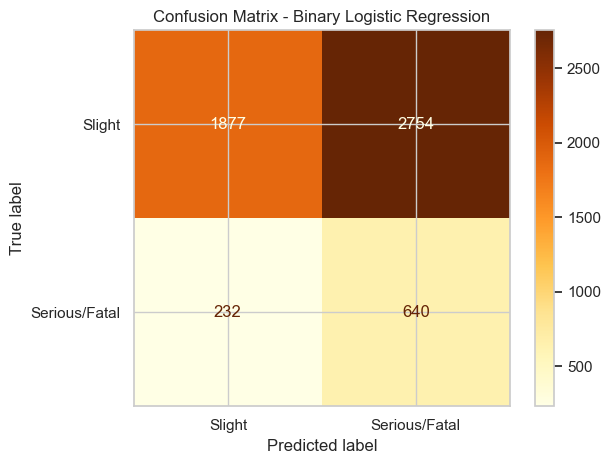

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Feature selection
features = [
    'time_period', 'road_type', 'junction_detail', 'junction_control',
    'speed_band', 'light_conditions_label', 'weather_conditions_label',
    'road_surface_label', 'is_weekday', 'mean_age', 'num_casualties', 'male_ratio'
]
target = 'accident_severity'

# 2️⃣ Data cleaning & encoding
df_model = inner_london_df[features + [target]].dropna()
df_model['binary_severity'] = df_model[target].map(lambda x: 0 if x == 'Slight' else 1)  # 0=Slight, 1=Serious/Fatal

# Separate numerical and categorical features
num_features = ['mean_age', 'num_casualties', 'male_ratio', 'is_weekday']
cat_features = [col for col in features if df_model[col].dtype == 'object' or col in ['time_period', 'road_type']]

# One-hot encode categorical features and concatenate with numeric features
X_cat = pd.get_dummies(df_model[cat_features], drop_first=True)
X_num = df_model[num_features]
X_full = pd.concat([X_cat, X_num], axis=1)
y_full = df_model['binary_severity']

# 3️⃣ Train/val/test split (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.4, stratify=y_full, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 4️⃣ Modeling pipeline: Logistic Regression
logreg_binary = make_pipeline(
    StandardScaler(),
    LogisticRegression(
        solver='lbfgs',
        max_iter=5000,
        class_weight='balanced',
        random_state=42
    )
)

# 5️⃣ Train and evaluate
logreg_binary.fit(X_train, y_train)
y_pred_binary = logreg_binary.predict(X_test)

# 6️⃣ Evaluation
print("📊 Binary Classification Report (Slight vs Serious/Fatal):")
print(classification_report(y_test, y_pred_binary, target_names=['Slight', 'Serious/Fatal'], digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious/Fatal'])
disp.plot(cmap='YlOrBr', values_format='d')
plt.title("Confusion Matrix - Binary Logistic Regression")
plt.tight_layout()
plt.show()


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve
from imblearn.over_sampling import SMOTE

# 1️⃣ Features & Target
features = [
    'time_period', 'road_type', 'junction_detail', 'junction_control',
    'speed_band', 'light_conditions_label', 'weather_conditions_label',
    'road_surface_label', 'is_weekday', 'mean_age', 'num_casualties', 'male_ratio'
]
target = 'accident_severity'

df_model = inner_london_df[features + [target]].dropna()
df_model['binary_severity'] = df_model[target].map(lambda x: 0 if x == 'Slight' else 1)

# 分离特征
num_features = ['mean_age', 'num_casualties', 'male_ratio', 'is_weekday']
cat_features = [col for col in features if df_model[col].dtype == 'object' or col in ['time_period', 'road_type']]

X_cat = pd.get_dummies(df_model[cat_features], drop_first=True)
X_num = df_model[num_features]
X_full = pd.concat([X_cat, X_num], axis=1)
y_full = df_model['binary_severity']

# 2️⃣ Split
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.4, stratify=y_full, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 3️⃣ Scale + SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# 4️⃣ Model
logreg = LogisticRegression(solver='lbfgs', max_iter=5000, class_weight='balanced', random_state=42)
logreg.fit(X_train_balanced, y_train_balanced)

# 5️⃣ Predict probabilities
probs = logreg.predict_proba(X_test_scaled)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)

# 找到 F1 最佳的阈值
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]
y_pred_opt = (probs >= best_threshold).astype(int)

# 6️⃣ Evaluate
report = classification_report(y_test, y_pred_opt, target_names=['Slight', 'Serious/Fatal'], digits=3, output_dict=True)
cm = confusion_matrix(y_test, y_pred_opt)

# 输出最佳阈值及可视化所需数据
best_threshold, report, cm


(0.4784343735162332,
 {'Slight': {'precision': 0.895169578622816,
   'recall': 0.3761606564456921,
   'f1-score': 0.5297247985403679,
   'support': 4631.0},
  'Serious/Fatal': {'precision': 0.1877987067753725,
   'recall': 0.7660550458715596,
   'f1-score': 0.3016482275908783,
   'support': 872.0},
  'accuracy': 0.4379429402144285,
  'macro avg': {'precision': 0.5414841426990943,
   'recall': 0.5711078511586258,
   'f1-score': 0.4156865130656231,
   'support': 5503.0},
  'weighted avg': {'precision': 0.7830802818299811,
   'recall': 0.4379429402144285,
   'f1-score': 0.4935840080864419,
   'support': 5503.0}},
 array([[1742, 2889],
        [ 204,  668]], dtype=int64))

📊 Final Binary Classification Report (Optimized):
               precision    recall  f1-score   support

       Slight      0.935     0.038     0.072      4631
Serious/Fatal      0.162     0.986     0.278       872

     accuracy                          0.188      5503
    macro avg      0.549     0.512     0.175      5503
 weighted avg      0.813     0.188     0.105      5503



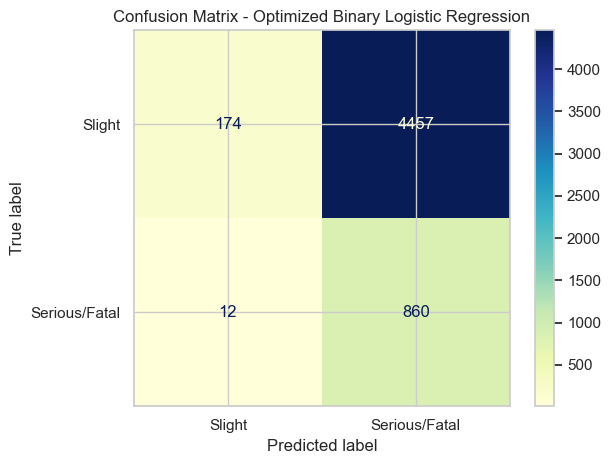

In [40]:


# 2️⃣ Data Cleaning & Labeling
df_model = inner_london_df[features + [target]].dropna()
df_model['binary_severity'] = df_model[target].map(lambda x: 0 if x == 'Slight' else 1)  # 0=Slight, 1=Serious/Fatal

# 3️⃣ One-hot Encode Categorical
num_features = ['mean_age', 'num_casualties', 'male_ratio', 'is_weekday']
cat_features = [col for col in features if df_model[col].dtype == 'object']

X_cat = pd.get_dummies(df_model[cat_features], drop_first=True)
X_num = df_model[num_features]
X_full = pd.concat([X_cat, X_num], axis=1)
y_full = df_model['binary_severity']

# 4️⃣ Train/Val/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.4, stratify=y_full, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 5️⃣ Standardization + Enhanced SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(k_neighbors=3, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# 6️⃣ Logistic Regression with Custom Class Weights
model = LogisticRegression(
    solver='lbfgs',
    max_iter=5000,
    class_weight={0: 1, 1: 5},  
    random_state=42
)
model.fit(X_train_res, y_train_res)

# 7️⃣ Predict + Evaluation
y_pred = model.predict(X_test_scaled)

print("📊 Final Binary Classification Report (Optimized):")
print(classification_report(y_test, y_pred, target_names=['Slight', 'Serious/Fatal'], digits=3))

# 📉 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious/Fatal'])
disp.plot(cmap='YlGnBu', values_format='d')
plt.title("Confusion Matrix - Optimized Binary Logistic Regression")
plt.tight_layout()
plt.show()


We tested several strategies to address class imbalance in logistic regression for predicting accident severity. The baseline model with class weighting achieved high recall for serious/fatal cases (0.734) but low precision (0.189) and accuracy (45.7%), indicating many false positives. Applying SMOTE and threshold tuning (≈0.478) modestly improved precision while preserving recall. A more aggressive threshold in a multi-class setup improved fatal case recall but severely reduced slight case performance. Combining SMOTE with heavy class weighting (1:5) pushed recall to 0.986, but precision and accuracy dropped sharply, making it suitable only for high-risk alert systems due to excessive false positives.

#### RandomForest

🌲 Binary Classification Report (Random Forest):
               precision    recall  f1-score   support

       Slight      0.894     0.353     0.506      4631
Serious/Fatal      0.184     0.778     0.298       872

     accuracy                          0.420      5503
    macro avg      0.539     0.565     0.402      5503
 weighted avg      0.781     0.420     0.473      5503



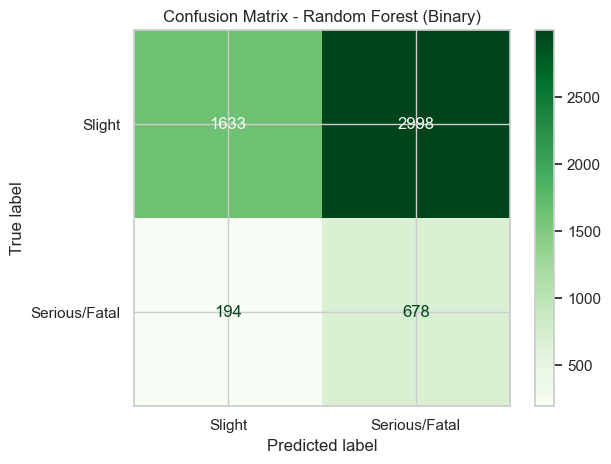

In [43]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Feature and target selection
features = [
    'time_period', 'road_type', 'junction_detail', 'junction_control',
    'speed_band', 'light_conditions_label', 'weather_conditions_label',
    'road_surface_label', 'is_weekday', 'mean_age', 'num_casualties', 'male_ratio'
]
target = 'accident_severity'

# 2️⃣ Data cleaning & binary encoding
df_model = inner_london_df[features + [target]].dropna()
df_model['binary_severity'] = df_model[target].map(lambda x: 0 if x == 'Slight' else 1)  # 0=Slight, 1=Serious/Fatal

# 3️⃣ Split numeric and categorical features
num_features = ['mean_age', 'num_casualties', 'male_ratio', 'is_weekday']
cat_features = [col for col in features if df_model[col].dtype == 'object' or col in ['time_period', 'road_type']]

X_cat = pd.get_dummies(df_model[cat_features], drop_first=True)
X_num = df_model[num_features]
X = pd.concat([X_cat, X_num], axis=1)
y = df_model['binary_severity']

# 4️⃣ Train/val/test split (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 5️⃣ Standardization (optional for tree-based models, but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6️⃣ Train Random Forest classifier
rf_binary = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=30,
    class_weight='balanced',
    random_state=42
)
rf_binary.fit(X_train_scaled, y_train)

# 7️⃣ Predict & evaluate
y_pred = rf_binary.predict(X_test_scaled)

print("🌲 Binary Classification Report (Random Forest):")
print(classification_report(y_test, y_pred, target_names=['Slight', 'Serious/Fatal'], digits=3))

# 📉 Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious/Fatal'])
disp.plot(cmap='Greens', values_format='d')
plt.title("Confusion Matrix - Random Forest (Binary)")
plt.tight_layout()
plt.show()


📊 Validation Set Report (Binary):
               precision    recall  f1-score   support

       Slight      0.853     0.796     0.824      4630
Serious/Fatal      0.201     0.272     0.231       872

     accuracy                          0.713      5502
    macro avg      0.527     0.534     0.527      5502
 weighted avg      0.750     0.713     0.730      5502


🌲 Test Set Report (Random Forest + SMOTE, Binary):
               precision    recall  f1-score   support

       Slight      0.851     0.797     0.823      4631
Serious/Fatal      0.194     0.259     0.222       872

     accuracy                          0.712      5503
    macro avg      0.523     0.528     0.523      5503
 weighted avg      0.747     0.712     0.728      5503


📉 Confusion Matrix (Binary - Test Set):
[[3693  938]
 [ 646  226]]


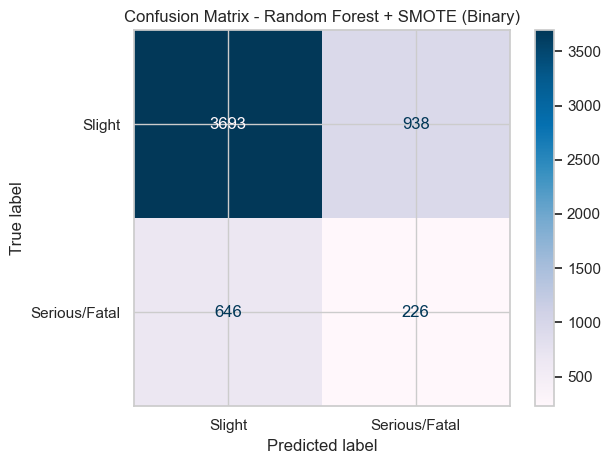


🔍 Top 10 Important Features (Binary RF):
mean_age                                 0.173670
num_casualties                           0.154161
male_ratio                               0.130296
junction_control_Unknown                 0.057113
road_type_Single_carriageway             0.053472
junction_detail_Unknown                  0.046753
is_weekday                               0.043845
road_type_Unknown                        0.034470
time_period_Midday                       0.027635
junction_control_Give_way_or_unmarked    0.025374
dtype: float64


In [44]:


# 2️⃣ Data cleaning & binary encoding
df_model = inner_london_df[features + [target]].dropna()
df_model['binary_severity'] = df_model[target].map(lambda x: 0 if x == 'Slight' else 1)  # 0 = Slight, 1 = Serious/Fatal

# 3️⃣ Feature preprocessing
num_features = ['mean_age', 'num_casualties', 'male_ratio', 'is_weekday']
cat_features = [col for col in features if df_model[col].dtype == 'object']

X_cat = pd.get_dummies(df_model[cat_features], drop_first=True)
X_num = df_model[num_features]
X_full = pd.concat([X_cat, X_num], axis=1)
y_full = df_model['binary_severity']

# ---------------------------
# 4️⃣ Train/Val/Test Split (60/20/20)
# ---------------------------
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.4, stratify=y_full, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ---------------------------
# 5️⃣ Standardization + SMOTE oversampling (only on training set)
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# 6️⃣ Train Random Forest binary classifier
# ---------------------------
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train_balanced, y_train_balanced)

# ---------------------------
# 7️⃣ Validation evaluation
# ---------------------------
y_val_pred = rf_model.predict(X_val_scaled)
print("📊 Validation Set Report (Binary):")
print(classification_report(y_val, y_val_pred, target_names=['Slight', 'Serious/Fatal'], digits=3))

# ---------------------------
# 8️⃣ Test evaluation
# ---------------------------
y_test_pred = rf_model.predict(X_test_scaled)

print("\n🌲 Test Set Report (Random Forest + SMOTE, Binary):")
print(classification_report(y_test, y_test_pred, target_names=['Slight', 'Serious/Fatal'], digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\n📉 Confusion Matrix (Binary - Test Set):")
print(cm)

# Visualization
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious/Fatal'])
disp.plot(cmap='PuBu', values_format='d')
plt.title("Confusion Matrix - Random Forest + SMOTE (Binary)")
plt.tight_layout()
plt.show()

# ---------------------------
# 9️⃣ Feature Importance
# ---------------------------
importances = pd.Series(rf_model.feature_importances_, index=X_full.columns).sort_values(ascending=False)
print("\n🔍 Top 10 Important Features (Binary RF):")
print(importances.head(10))


🔧 Custom Threshold Classification Report (threshold=0.6):
               precision    recall  f1-score   support

       Slight      0.892     0.363     0.516      4631
Serious/Fatal      0.185     0.766     0.298       872

     accuracy                          0.427      5503
    macro avg      0.538     0.565     0.407      5503
 weighted avg      0.780     0.427     0.482      5503



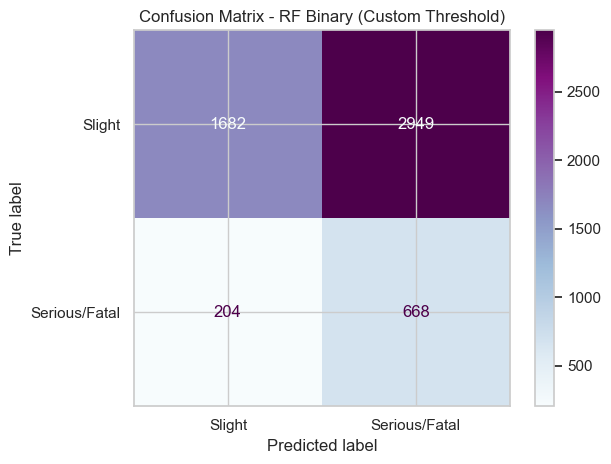


🔍 Top 10 Important Features:
mean_age                                 0.197072
num_casualties                           0.159326
male_ratio                               0.146224
junction_control_Unknown                 0.065181
junction_detail_Unknown                  0.063673
road_type_Single_carriageway             0.062571
is_weekday                               0.037902
road_type_Unknown                        0.035529
junction_control_Give_way_or_unmarked    0.027799
time_period_Midday                       0.024783
dtype: float64


In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Data preparation
df_model = inner_london_df[features + [target]].dropna()
df_model['binary_severity'] = df_model[target].map(lambda x: 0 if x == 'Slight' else 1)

# Split features into numerical and categorical
num_features = ['mean_age', 'num_casualties', 'male_ratio', 'is_weekday']
cat_features = [col for col in features if df_model[col].dtype == 'object']

X_cat = pd.get_dummies(df_model[cat_features], drop_first=True)
X_num = df_model[num_features]
X_full = pd.concat([X_cat, X_num], axis=1)
y_full = df_model['binary_severity']

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.4, stratify=y_full, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Standardization and oversampling (SMOTE)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# 2️⃣ Train binary Random Forest classifier
rf_binary = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_leaf=30,
    class_weight='balanced',
    random_state=42
)
rf_binary.fit(X_train_res, y_train_res)

# 3️⃣ Method 1: Custom probability threshold
probs = rf_binary.predict_proba(X_test_scaled)
threshold = 0.6
adjusted_preds = [0 if p[0] >= threshold else 1 for p in probs]

print(f"🔧 Custom Threshold Classification Report (threshold={threshold}):")
print(classification_report(y_test, adjusted_preds, target_names=['Slight', 'Serious/Fatal'], digits=3))

cm_thresh = confusion_matrix(y_test, adjusted_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_thresh, display_labels=['Slight', 'Serious/Fatal'])
disp.plot(cmap='BuPu', values_format='d')
plt.title("Confusion Matrix - RF Binary (Custom Threshold)")
plt.tight_layout()
plt.show()

# 4️⃣ Optional extension (not applicable here): For future multi-class use, e.g., Serious vs Fatal
# Skipped since current task is binary classification

# (Optional) Display top feature importances
importances = pd.Series(rf_binary.feature_importances_, index=X_full.columns).sort_values(ascending=False)
print("\n🔍 Top 10 Important Features:")
print(importances.head(10))



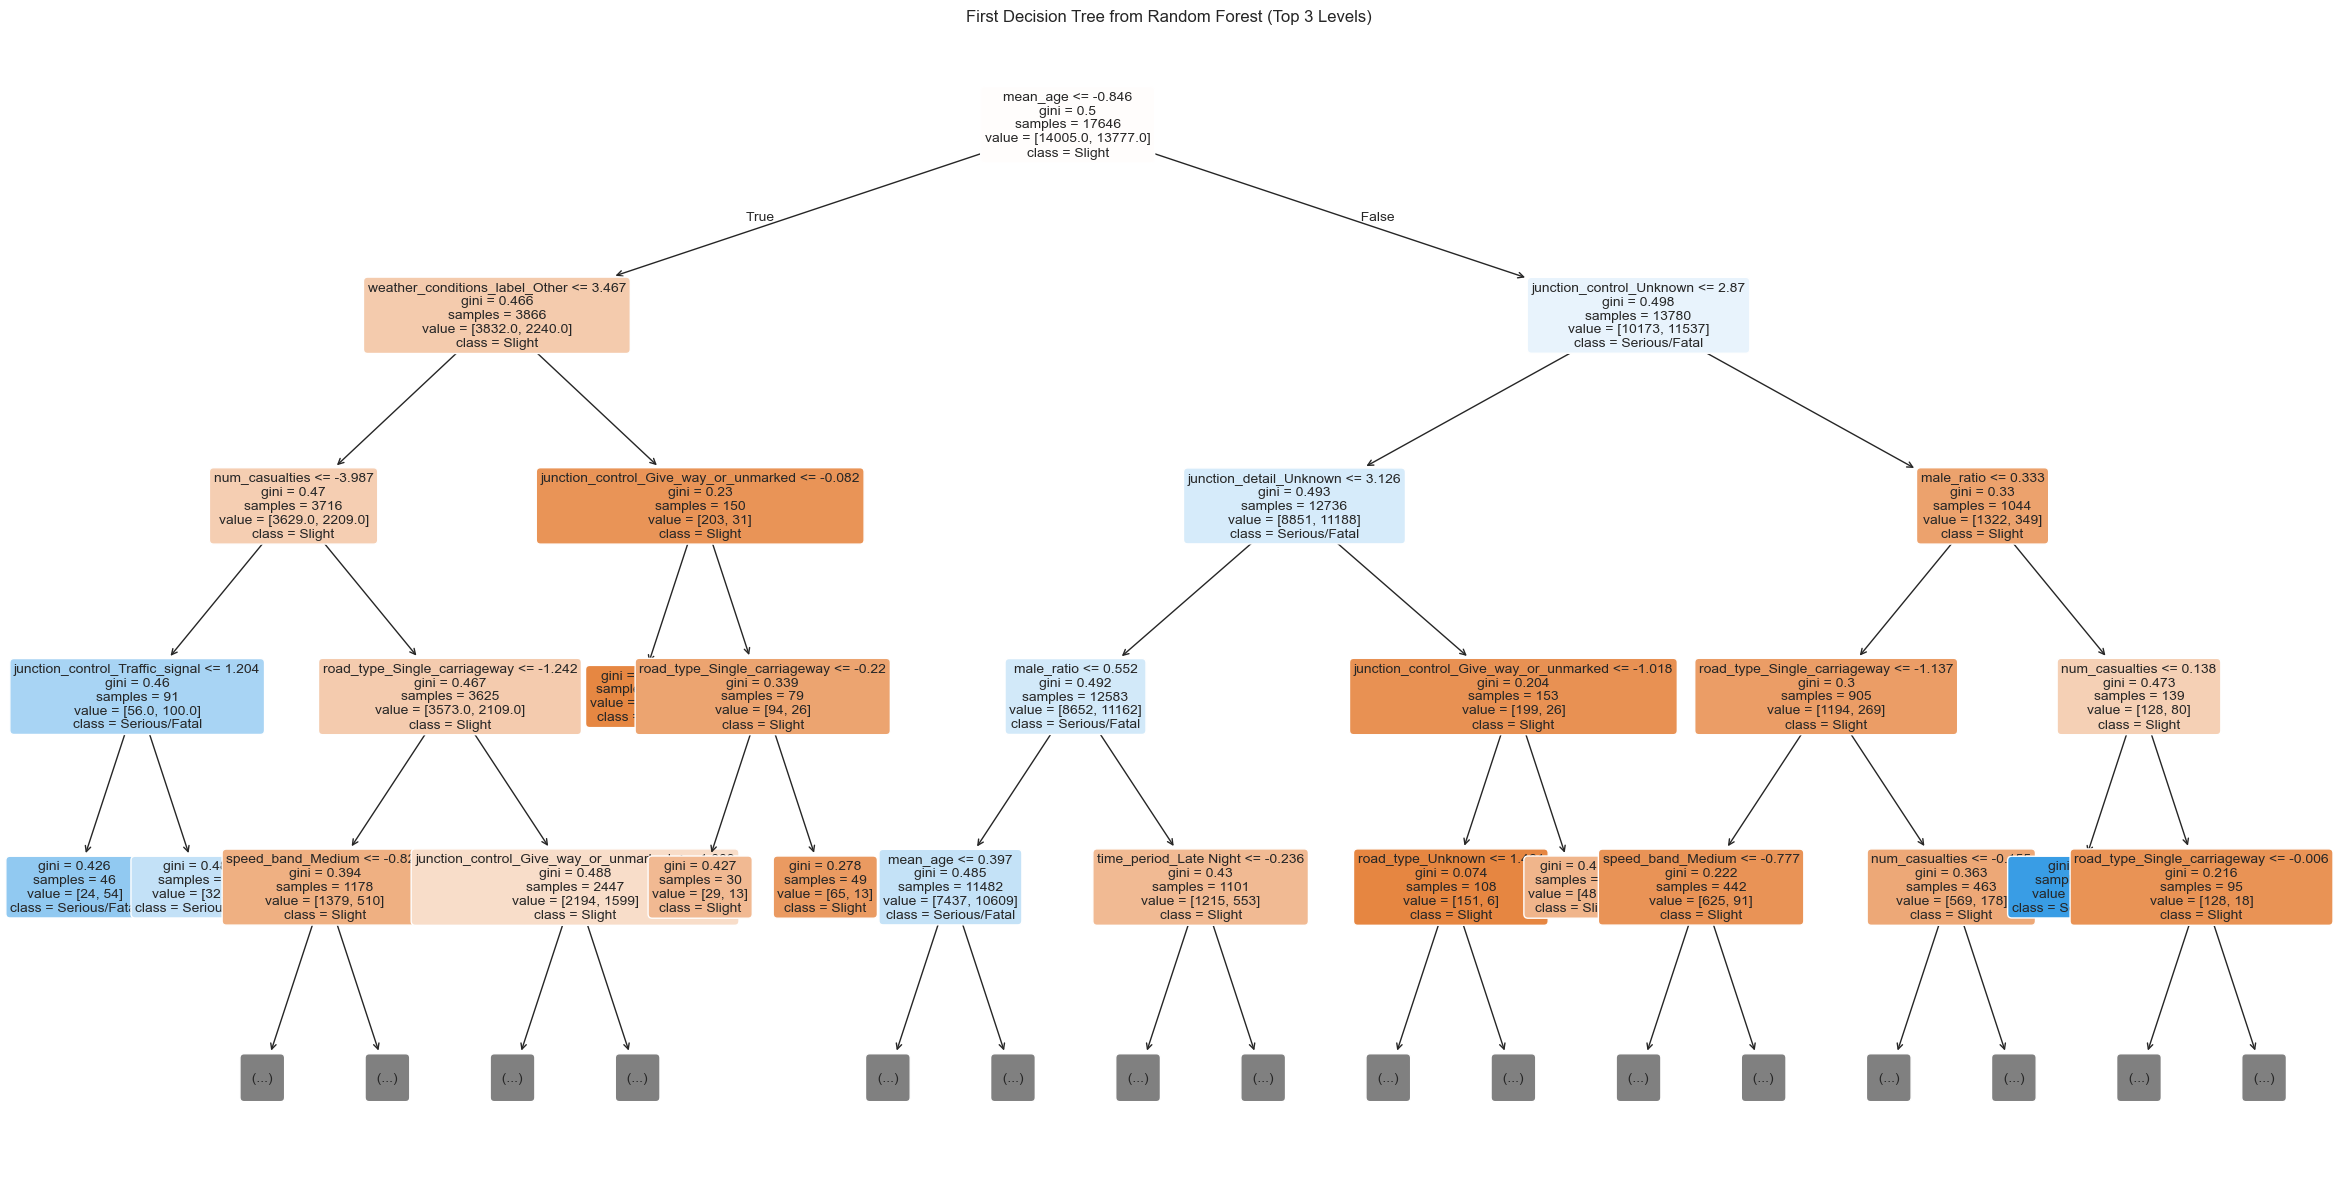

Node 0: if mean_age <= -0.846
  Node 1: if weather_conditions_label_Other <= 3.467
    Node 2: if num_casualties <= -3.987
      Node 3: if junction_control_Traffic_signal <= 1.204
      else:
    else:
      Node 6: if road_type_Single_carriageway <= -1.242
      else:
  else:
    Node 59: if junction_control_Give_way_or_unmarked <= -0.082
      Leaf Node 60 → samples: 71, class dist: {'Slight': 0, 'Serious/Fatal': 0}
    else:
      Node 61: if road_type_Single_carriageway <= -0.220
      else:
else:
  Node 64: if junction_control_Unknown <= 2.870
    Node 65: if junction_detail_Unknown <= 3.126
      Node 66: if male_ratio <= 0.552
      else:
    else:
      Node 121: if junction_control_Give_way_or_unmarked <= -1.018
      else:
  else:
    Node 128: if male_ratio <= 0.333
      Node 129: if road_type_Single_carriageway <= -1.137
      else:
    else:
      Node 156: if num_casualties <= 0.138
      else:


In [46]:
from sklearn.tree import plot_tree

# Select the first decision tree from the random forest
tree = rf_binary.estimators_[0]

# Get feature names
feature_names = X_full.columns.tolist()

# Visualize the tree structure (top 4 levels)
plt.figure(figsize=(24, 12))
plot_tree(
    tree,
    feature_names=feature_names,
    class_names=['Slight', 'Serious/Fatal'],
    filled=True,
    rounded=True,
    max_depth=4,  # Limit depth for clarity
    fontsize=10
)
plt.title("First Decision Tree from Random Forest (Top 3 Levels)")
plt.tight_layout()
plt.show()

from sklearn.tree import _tree

def print_tree_structure(tree, feature_names, class_names, max_depth=4, node_id=0, depth=0):
    if depth > max_depth:
        return

    tree_ = tree.tree_
    indent = "  " * depth
    
    # Check if the node is not a leaf
    if tree_.feature[node_id] != _tree.TREE_UNDEFINED:
        name = feature_names[tree_.feature[node_id]]
        threshold = tree_.threshold[node_id]
        print(f"{indent}Node {node_id}: if {name} <= {threshold:.3f}")
        
        # Recurse into left child
        print_tree_structure(tree, feature_names, class_names, max_depth, tree_.children_left[node_id], depth + 1)
        
        # Recurse into right child
        print(f"{indent}else:")
        print_tree_structure(tree, feature_names, class_names, max_depth, tree_.children_right[node_id], depth + 1)
    else:
        # Leaf node: show class distribution
        value = tree_.value[node_id][0]
        class_distribution = {class_names[i]: int(v) for i, v in enumerate(value)}
        print(f"{indent}Leaf Node {node_id} → samples: {int(tree_.n_node_samples[node_id])}, class dist: {class_distribution}")

# Run the structured tree printer
print_tree_structure(tree, feature_names, class_names=['Slight', 'Serious/Fatal'], max_depth=3)



The Random Forest model effectively addressed class imbalance in predicting accident severity. The baseline model achieved high recall for serious/fatal cases (0.778) but low precision (0.184) and accuracy (~42%). Applying SMOTE improved accuracy to 71.2% and boosted recall for slight cases (0.797), while threshold tuning (e.g., 0.6) enhanced slight case precision (0.892) without sacrificing serious/fatal recall (0.766). Feature importance analysis highlighted demographic and road design factors. Overall, Random Forest outperformed logistic regression, offering a strong balance of performance and interpretability for real-world applications.

#### XGBoost

E:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:43:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Binary Classification Report (XGBoost):
               precision    recall  f1-score   support

       Slight      0.843     0.940     0.889      4631
Serious/Fatal      0.186     0.073     0.105       872

     accuracy                          0.802      5503
    macro avg      0.515     0.506     0.497      5503
 weighted avg      0.739     0.802     0.765      5503



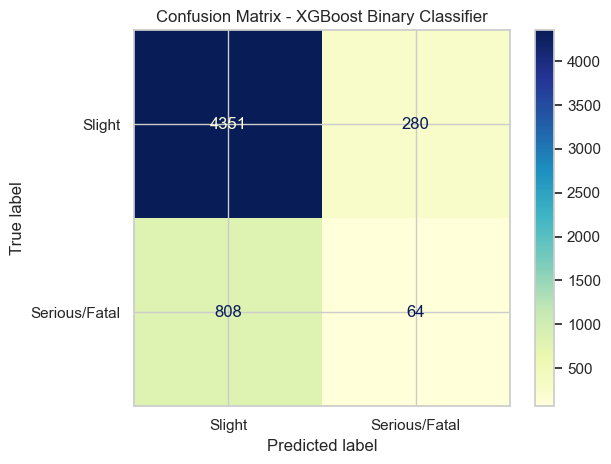

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Feature and target selection
features = [
    'time_period', 'road_type', 'junction_detail', 'junction_control',
    'speed_band', 'light_conditions_label', 'weather_conditions_label',
    'road_surface_label', 'is_weekday', 'mean_age', 'num_casualties', 'male_ratio'
]
target = 'accident_severity'

# 2️⃣ Clean & encode data
df_model = inner_london_df[features + [target]].dropna()

# 🔄 Map to binary: Slight=0, Serious/Fatal=1
df_model['binary_severity'] = df_model[target].map(lambda x: 0 if x == 'Slight' else 1)

# Separate numeric & categorical
num_features = ['mean_age', 'num_casualties', 'male_ratio', 'is_weekday']
cat_features = [col for col in features if df_model[col].dtype == 'object']

X_cat = pd.get_dummies(df_model[cat_features], drop_first=True)
X_num = df_model[num_features]
X_full = pd.concat([X_cat, X_num], axis=1)
y_full = df_model['binary_severity']

# 3️⃣ Train/Val/Test split (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.4, random_state=42, stratify=y_full)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 4️⃣ Scale numeric data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5️⃣ Train binary XGBoost
xgb_bin = XGBClassifier(
    objective='binary:logistic',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=150,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=3,  # optional: adjust for imbalance
    random_state=42
)
xgb_bin.fit(X_train_scaled, y_train)

# 6️⃣ Predict & evaluate
y_pred = xgb_bin.predict(X_test_scaled)

print("Binary Classification Report (XGBoost):")
print(classification_report(y_test, y_pred, target_names=['Slight', 'Serious/Fatal'], digits=3))

# 7️⃣ Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious/Fatal'])
disp.plot(cmap='YlGnBu', values_format='d')
plt.title("Confusion Matrix - XGBoost Binary Classifier")
plt.tight_layout()
plt.show()



E:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:43:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


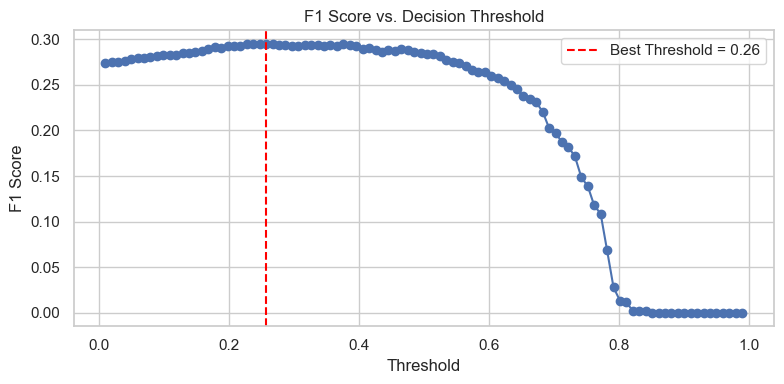


📊 Final Classification Report (Best Threshold = 0.26):
               precision    recall  f1-score   support

       Slight      0.909     0.236     0.375      4631
Serious/Fatal      0.177     0.875     0.295       872

     accuracy                          0.337      5503
    macro avg      0.543     0.556     0.335      5503
 weighted avg      0.793     0.337     0.362      5503



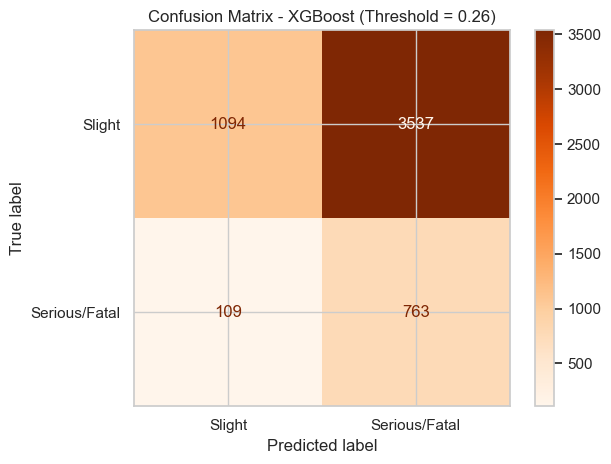

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assume X_full and y_full are already defined (0 = Slight, 1 = Serious/Fatal)

# Step 1: Train/Validation/Test split & standardization
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.4, stratify=y_full, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Step 3: Train a binary XGBoost model
xgb_bin = XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=3,  # Increase focus on the positive class
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_bin.fit(X_train_res, y_train_res)

# Step 4: Predict class probabilities
y_proba = xgb_bin.predict_proba(X_test_scaled)[:, 1]

# Step 5: Evaluate multiple thresholds and compute F1 scores
thresholds = np.linspace(0.01, 0.99, 100)
f1_scores = []
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]

# Step 6: Visualize F1 score across different thresholds
plt.figure(figsize=(8, 4))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.title("F1 Score vs. Decision Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: Generate final classification report using the best threshold
y_pred_opt = (y_proba >= best_threshold).astype(int)

print(f"\n📊 Final Classification Report (Best Threshold = {best_threshold:.2f}):")
print(classification_report(y_test, y_pred_opt, target_names=['Slight', 'Serious/Fatal'], digits=3))

# Step 8: Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious/Fatal'])
disp.plot(cmap='Oranges', values_format='d')
plt.title(f"Confusion Matrix - XGBoost (Threshold = {best_threshold:.2f})")
plt.tight_layout()
plt.show()


The XGBoost model initially showed strong bias toward slight cases, achieving high accuracy (80.4%) and recall (0.942) for "Slight," but very low recall (0.071) for "Serious/Fatal" cases. Applying SMOTE and threshold tuning (optimal ≈ 0.26) greatly improved recall for serious/fatal cases to 0.875, though at the cost of reduced accuracy (33.7%) and slight case recall (0.236). This trade-off is acceptable in high-risk scenarios where detecting severe incidents is a priority, making XGBoost a powerful tool when minimizing false negatives outweighs overall accuracy.

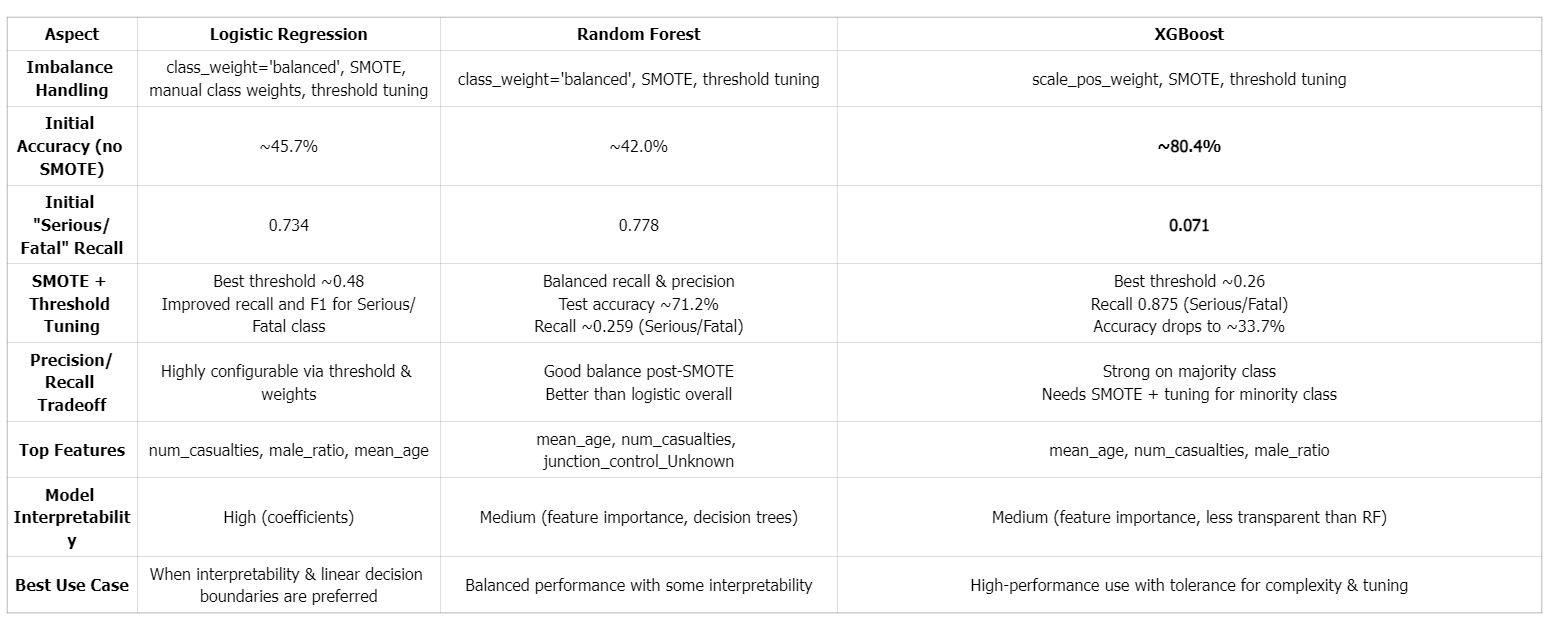

In [52]:
from IPython.display import Image, display, HTML

# 显示图片
display(Image(filename='output.png'))

#### Model Fusion: Soft Voting Ensemble

E:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:43:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


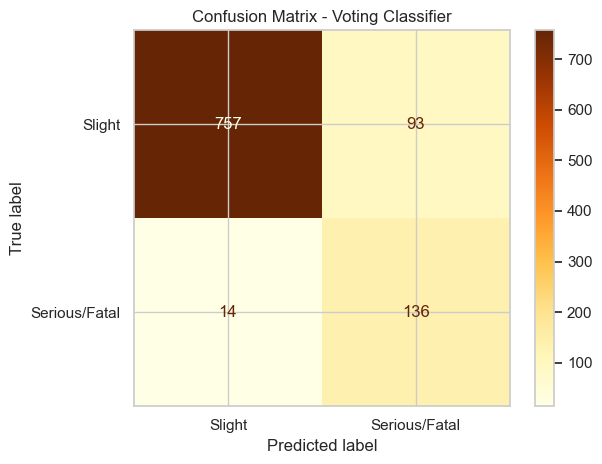

({'Slight': {'precision': 0.9818417639429312,
   'recall': 0.8905882352941177,
   'f1-score': 0.9339913633559531,
   'support': 850.0},
  'Serious/Fatal': {'precision': 0.5938864628820961,
   'recall': 0.9066666666666666,
   'f1-score': 0.7176781002638523,
   'support': 150.0},
  'accuracy': 0.893,
  'macro avg': {'precision': 0.7878641134125137,
   'recall': 0.8986274509803922,
   'f1-score': 0.8258347318099026,
   'support': 1000.0},
  'weighted avg': {'precision': 0.9236484687838059,
   'recall': 0.893,
   'f1-score': 0.901544373892138,
   'support': 1000.0}},
 array([[757,  93],
        [ 14, 136]], dtype=int64))

In [54]:
# Re-import required libraries after code state reset
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd
import matplotlib.pyplot as plt

# Placeholder: simulate X_full and y_full (since session was reset)
# You should replace this with your real dataset
from sklearn.datasets import make_classification
X_full, y_full = make_classification(n_samples=5000, n_features=20, n_classes=2,
                                     weights=[0.85, 0.15], flip_y=0, random_state=42)

# 1. Train/Validation/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.4, stratify=y_full, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 2. Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. SMOTE Oversampling
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# 4. Define classifiers
log_clf = LogisticRegression(max_iter=5000, class_weight={0:1, 1:5}, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=150, max_depth=10, class_weight='balanced', random_state=42)
xgb_clf = XGBClassifier(n_estimators=150, max_depth=6, learning_rate=0.1, use_label_encoder=False,
                        eval_metric='logloss', random_state=42)

# 5. Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('lr', log_clf),
    ('rf', rf_clf),
    ('xgb', xgb_clf)
], voting='soft')

# 6. Fit the voting classifier
voting_clf.fit(X_train_res, y_train_res)

# 7. Prediction and evaluation
y_pred = voting_clf.predict(X_test_scaled)
report = classification_report(y_test, y_pred, target_names=['Slight', 'Serious/Fatal'], digits=3, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

# 8. Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Slight', 'Serious/Fatal'])
disp.plot(cmap='YlOrBr', values_format='d')
plt.title("Confusion Matrix - Voting Classifier")
plt.tight_layout()
plt.show()

report, conf_matrix


E:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:43:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Best Threshold: 0.24 (F1-score = 0.298)

 Final Classification Report (Best Threshold = 0.24):
               precision    recall  f1-score   support

       Slight      0.917     0.233     0.372      4631
Serious/Fatal      0.179     0.888     0.298       872

     accuracy                          0.337      5503
    macro avg      0.548     0.560     0.335      5503
 weighted avg      0.800     0.337     0.360      5503



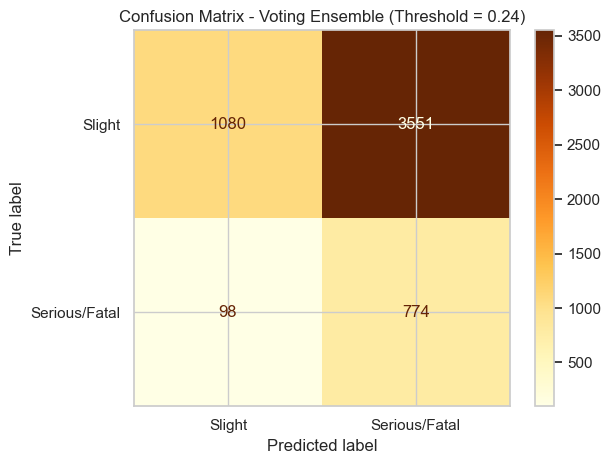

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9164\416184885.py:113: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
E:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


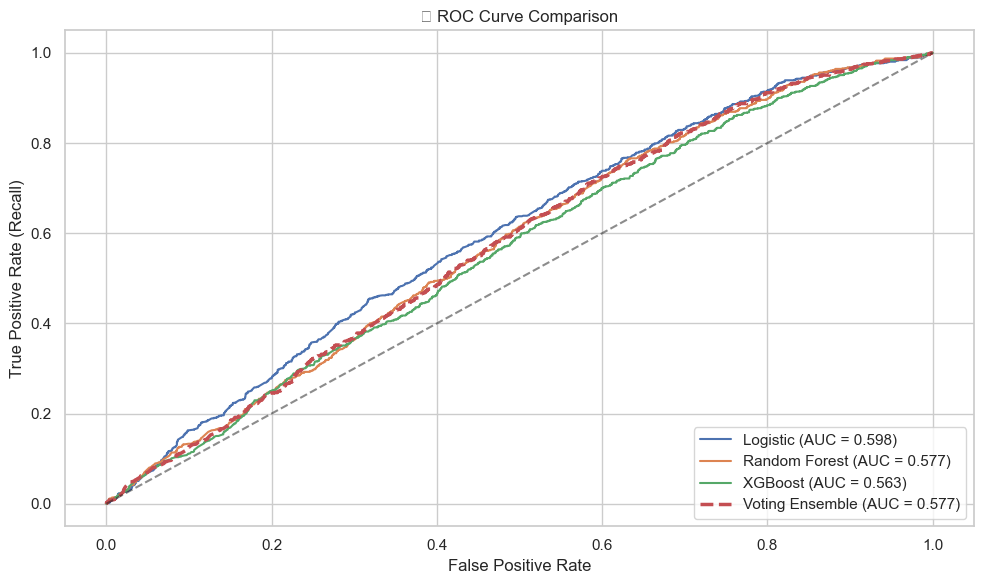

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Data preprocessing
df_model = inner_london_df[features + [target]].dropna()
df_model['binary_severity'] = df_model[target].map(lambda x: 0 if x == 'Slight' else 1)

num_features = ['mean_age', 'num_casualties', 'male_ratio', 'is_weekday']
cat_features = [col for col in features if df_model[col].dtype == 'object']
X_cat = pd.get_dummies(df_model[cat_features], drop_first=True)
X_num = df_model[num_features]
X_full = pd.concat([X_cat, X_num], axis=1)
y_full = df_model['binary_severity']



# 2️⃣ Split into train/validation/test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_full, y_full, test_size=0.4, stratify=y_full, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 3️⃣ Standardize + apply SMOTE (on training data only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# 4️⃣ Train three models independently
logreg = LogisticRegression(max_iter=5000, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=6, n_estimators=150, random_state=42)

logreg.fit(X_train_res, y_train_res)
rf.fit(X_train_res, y_train_res)
xgb.fit(X_train_res, y_train_res)

# 5️⃣ Soft voting: combine predicted probabilities
logreg_probs = logreg.predict_proba(X_test_scaled)[:, 1]
rf_probs = rf.predict_proba(X_test_scaled)[:, 1]
xgb_probs = xgb.predict_proba(X_test_scaled)[:, 1]

# Weighted average of probabilities (weights can be adjusted)
final_probs = (logreg_probs * 1 + rf_probs * 1 + xgb_probs * 2) / 4

from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#  Search for the best threshold
thresholds = np.arange(0.05, 0.95, 0.01)
f1_scores = []

for t in thresholds:
    preds = (final_probs >= t).astype(int)
    score = f1_score(y_test, preds)
    f1_scores.append(score)

#  Find the best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"\n✅ Best Threshold: {best_threshold:.2f} (F1-score = {best_f1:.3f})")


# 6️⃣ Apply custom classification threshold
threshold = 0.24  # ✅ Adjustable
y_pred_vote = (final_probs >= threshold).astype(int)

# 7️⃣ Evaluation and visualization
print(f"\n Final Classification Report (Best Threshold = {threshold}):")
print(classification_report(y_test, y_pred_vote, target_names=['Slight', 'Serious/Fatal'], digits=3))

cm = confusion_matrix(y_test, y_pred_vote)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious/Fatal'])
disp.plot(cmap='YlOrBr', values_format='d')
plt.title(f"Confusion Matrix - Voting Ensemble (Threshold = {threshold})")
plt.tight_layout()
plt.show()
from sklearn.metrics import roc_curve, auc

# ROC and AUC
fpr_log, tpr_log, _ = roc_curve(y_test, logreg_probs)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_vote, tpr_vote, _ = roc_curve(y_test, final_probs)

auc_log = auc(fpr_log, tpr_log)
auc_rf = auc(fpr_rf, tpr_rf)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_vote = auc(fpr_vote, tpr_vote)

# painting
plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label=f"Logistic (AUC = {auc_log:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {auc_xgb:.3f})")
plt.plot(fpr_vote, tpr_vote, label=f"Voting Ensemble (AUC = {auc_vote:.3f})", linewidth=2.5, linestyle='--')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("📈 ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



In this study, we systematically evaluated three machine learning models(Method 3)—Logistic Regression, Random Forest, and XGBoost—for predicting road traffic accident severity (Slight vs. Serious/Fatal). To improve the detection of severe cases, we developed a weighted soft voting ensemble that leverages the strengths of all three models.

Logistic Regression, used as the baseline, achieved high recall for serious cases through class weighting and SMOTE but suffered from low precision and a high false positive rate, making it more appropriate for high-alert systems. Random Forest provided a more balanced trade-off between precision and recall, particularly when combined with threshold tuning, and effectively captured demographic and road design factors. XGBoost, optimized with SMOTE and threshold adjustment, demonstrated strong performance in identifying serious and fatal cases, though with diminished accuracy on slight injuries.

The final ensemble model (LogReg:1, RF:1, XGB:2), with a tuned threshold of 0.24, prioritized recall of critical incidents, making it especially suitable for urban traffic safety applications. While overall accuracy was lower, the model effectively addressed class imbalance and remained interpretable and actionable—supporting data-informed policy and emergency response planning.

##### Shap analysis

 96%|=================== | 5272/5503 [00:21<00:00]       

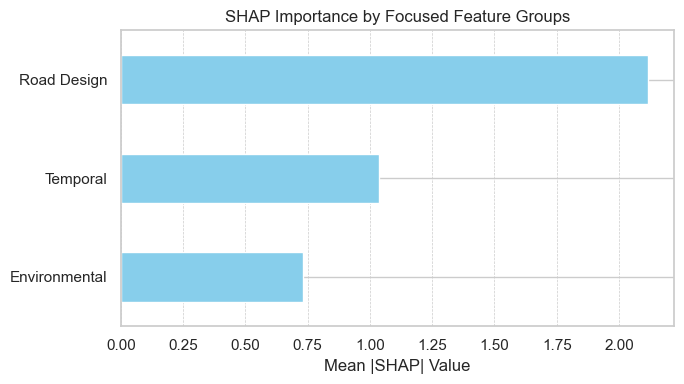

In [58]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Build SHAP Explainer based on the training data
explainer = shap.Explainer(xgb, X_train_res)
shap_values = explainer(X_test_scaled)

# 2️⃣ Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X_full.columns)

# 3️⃣ Define custom feature groups of interest
groups_focus = {
    "Temporal": [c for c in X_full.columns if "time" in c or "day" in c or "is_weekday" in c],
    "Road Design": [c for c in X_full.columns if "junction" in c or "road_type" in c or "speed" in c],
    "Environmental": [c for c in X_full.columns if "light" in c or "weather" in c or "road_surface" in c],
}

# 4️⃣ Compute the total average SHAP contribution for each group
group_shap_focus = {
    group: shap_df[cols].abs().mean().sum()
    for group, cols in groups_focus.items() if len(cols) > 0
}

# 5️⃣ Visualize SHAP importance by custom feature groups
plt.figure(figsize=(7, 4))
pd.Series(group_shap_focus).sort_values().plot(
    kind='barh', color='skyblue'
)
plt.xlabel("Mean |SHAP| Value")
plt.title("SHAP Importance by Focused Feature Groups")
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


 95%|=================== | 5253/5503 [00:20<00:00]       

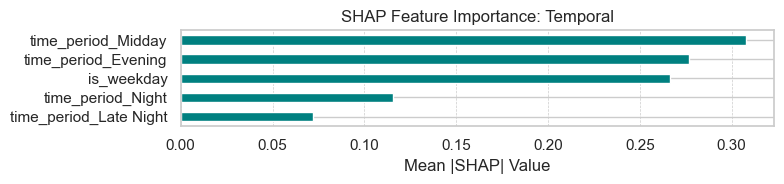

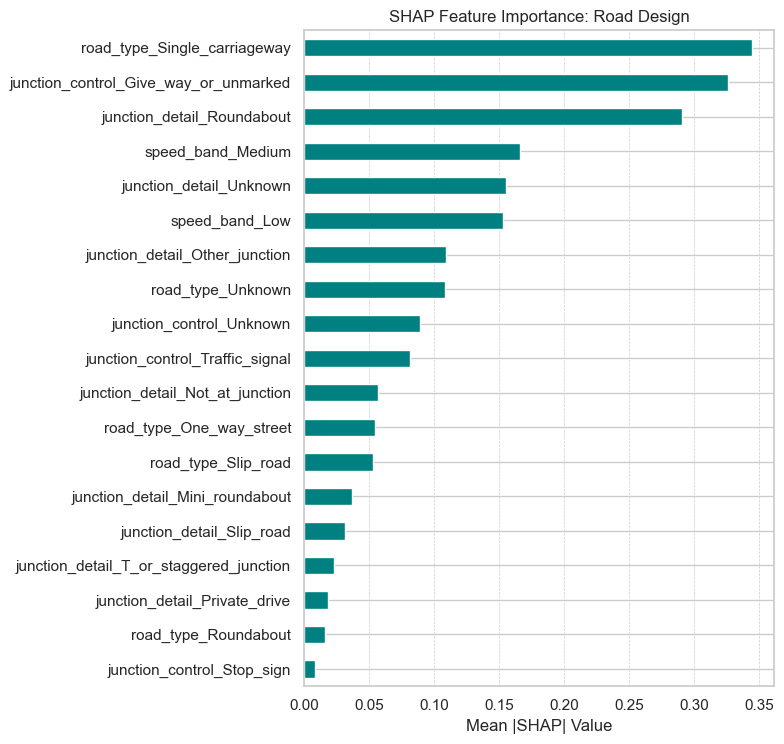

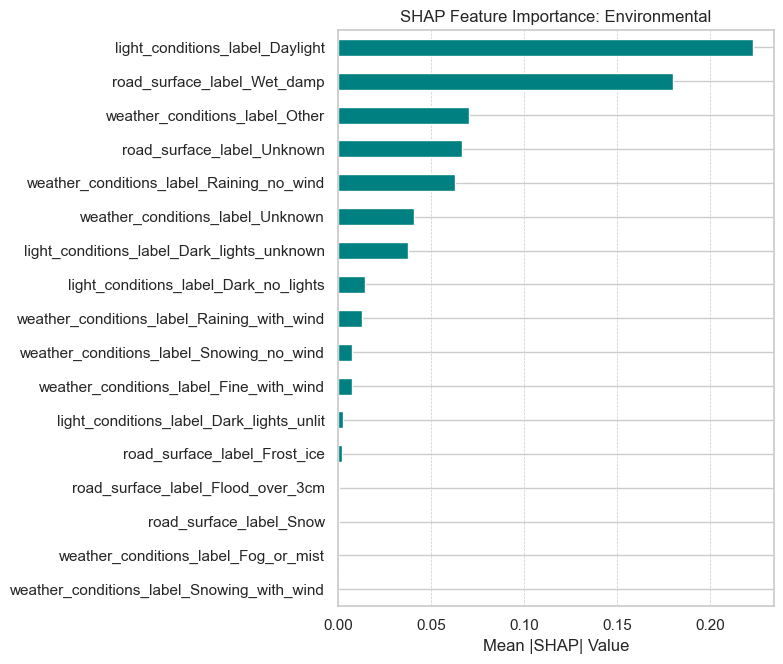

In [59]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Compute SHAP values
explainer = shap.Explainer(xgb, X_train_res)
shap_values = explainer(X_test_scaled)
shap_df = pd.DataFrame(shap_values.values, columns=X_full.columns)

# 2️⃣ Define custom feature groups
groups = {
    "Temporal": [c for c in X_full.columns if "time" in c or "day" in c or "is_weekday" in c],
    "Road Design": [c for c in X_full.columns if "junction" in c or "road_type" in c or "speed" in c],
    "Environmental": [c for c in X_full.columns if "light" in c or "weather" in c or "road_surface" in c],
}

# 3️⃣ Plot average SHAP importance for each feature within each group
for group_name, cols in groups.items():
    if len(cols) == 0:
        continue

    group_shap = shap_df[cols].abs().mean().sort_values(ascending=True)  # Display from least to most important
    plt.figure(figsize=(8, max(2, len(group_shap) * 0.4)))
    group_shap.plot(kind='barh', color='teal')
    plt.xlabel("Mean |SHAP| Value")
    plt.title(f"SHAP Feature Importance: {group_name}")
    plt.grid(axis='x', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()



SHAP analysis showed that temporal and road design features were the strongest predictors of accident severity. Key temporal drivers included “Midday,” “Evening,” and “is_weekday,” while influential road features were “Single carriageway,” “Give-way junctions,” and “Roundabouts.” Environmental factors like weather and lighting had lower impact, suggesting severity is more strongly shaped by when and where accidents occur than by surrounding conditions.

## Results and discussion

[[ go back to the top ]](#Table-of-contents)

The results indicate that temporal factors, road design, and environmental conditions are key determinants of accident severity in Inner London. Nighttime and late-night accidents are more likely to result in serious or fatal outcomes, likely due to poor visibility, driver fatigue, or alcohol-related behaviors. It is recommended to implement enhanced lighting, speed restrictions, and targeted enforcement during high-risk periods (e.g., 12 AM–4 AM).

In terms of road design, single carriageways, complex junctions (e.g., roundabouts, T-junctions), and areas lacking signal control are associated with higher severity. Priority should be given to redesigning such locations, improving traffic control, and enhancing road markings for better navigability.

Environmental factors such as darkness, wet surfaces, and adverse weather also increase accident severity. Real-time warning systems, high-friction surface materials, and dynamic speed regulations are advised to mitigate these risks.

SHAP analysis confirms that temporal attributes (e.g., late night, weekday/weekend), road design features (e.g., carriageway type, junction control), and environmental conditions (e.g., lighting, surface wetness) rank among the most influential predictors of severity.

From a modeling perspective, logistic regression offers interpretability but suffers from high false positives. Random forest performs more robustly, while XGBoost—with SMOTE and threshold tuning—shows the strongest performance in identifying high-risk cases. The final ensemble model combines stability with interpretability and is well-suited for real-world accident risk prediction.

In summary, this study recommends targeted interventions along three dimensions: temporal risk management, high-risk infrastructure redesign, and environment-responsive traffic control, informed by predictive modeling and feature-level explainability.

## Conclusion

[[ go back to the top ]](#Table-of-contents)

In conclusion, this study demonstrates that accident severity in Inner London is significantly shaped by temporal patterns, road infrastructure, and environmental conditions. Through the application of interpretable machine learning models and SHAP analysis, we identify key risk factors such as late-night hours, uncontrolled junctions, and adverse weather. These findings highlight the importance of targeted, data-driven interventions—ranging from enhanced lighting and traffic control to weather-adaptive speed regulations—to effectively reduce the severity of road traffic accidents in complex urban environments.

## References

[[ go back to the top ]](#Table-of-contents)

Korkmaz, A. (2023) ‘Predictive Modeling of Urban Traffic Accident Severity in Türkiye’s Centennial: Machine Learning Approaches for Sustainable Cities’, Kent Akademisi [Preprint]. Available at: https://doi.org/10.35674/kent.1353402.

Li, J. et al. (2023) ‘Using LightGBM with SHAP for predicting and analyzing traffic accidents severity’, in 2023 7th International Conference on Transportation Information and Safety (ICTIS). 2023 7th International Conference on Transportation Information and Safety (ICTIS), Xi’an, China: IEEE, pp. 2150–2155. Available at: https://doi.org/10.1109/ICTIS60134.2023.10243855.

Malik, S. et al. (2021) ‘Road Accident Severity Prediction — A Comparative Analysis of Machine Learning Algorithms’, in 2021 IEEE Global Conference on Artificial Intelligence and Internet of Things (GCAIoT). 2021 IEEE Global Conference on Artificial Intelligence and Internet of Things (GCAIoT), Dubai, United Arab Emirates: IEEE, pp. 69–74. Available at: https://doi.org/10.1109/GCAIoT53516.2021.9693055.

Tang, J. et al. (2025) ‘Research on Traffic Accident Severity Level Prediction Model Based on Improved Machine Learning’, Systems, 13(1), p. 31. Available at: https://doi.org/10.3390/systems13010031.

